In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set()

In [2]:
class HIVTreatment:
    def __init__(self, args):
        self.state_names = ("T1", "T1*", "T2", "T2*", "V", "E")
    
        self.continuous_dims = np.arange(6)
        self.actions = np.array([[0., 0.], [.7, 0.], [0., .3], [.7, .3]])
        self.nA = 4
        self.episodeCap = args.episodeCap  #: total of 1000 days with a measurement every 5 days
        self.dt = 5  #: measurement every 5 days
        self.logspace = True  #: whether observed states are in log10 space or not
        #: only update the graphs in showDomain every x steps
        self.show_domain_every = 20
        # store samples of current episode for drawing
        self.episode_data = np.zeros((7, self.episodeCap + 1))

        if self.logspace:
            self.statespace_limits = np.array([[-5, 8]] * 6)
        else:
            self.statespace_limits = np.array([[0., 1e8]] * 6)
        self.state_space_dims = 6
        
        self.action_noise = args.action_noise
        self.action_sigma = args.action_sigma
        self.drop_p = args.drop_p
        
    def step(self, a):
        self.t += 1

        eps1, eps2 = self.actions[a]
        drop = False
        for mini_step in range(self.dt):
            eps1_noisy = max(eps1 + np.random.normal(self.action_noise, self.action_sigma), 0.0)
            eps2_noisy = max(eps2 + np.random.normal(self.action_noise, self.action_sigma), 0.0)
            
            p_drop = self.drop_p * (self.dt + 1 - mini_step)**-1
            if np.random.rand() <= p_drop or drop:
                eps1_noisy = 0
                eps2_noisy = 0
                drop = True
            ns = odeint(dsdt, self.state, [0, 1], #changed [0, dt] to [0, 1]
                    args=(eps1_noisy, eps2_noisy), mxstep=1000)[-1]
            T1, T2, T1s, T2s, V, E = ns
            # the reward function penalizes treatment because of side-effects
            reward = (- 0.1 * V - 2e4 * eps1_noisy ** 2 - 2e3 * eps2_noisy ** 2 + 1e3 * E)/1e5
            self.state = ns.copy()
            if self.logspace:
                ns = np.log10(ns)

        self.episode_data[:-1, self.t] = self.state
        self.episode_data[-1, self.t - 1] = a
        return self.normalizeState(ns), reward, self.isTerminal(), self.possibleActions()
    def normalizeState(self, s):
        return (s - self.statespace_limits[:, 0])/(self.statespace_limits[:, 1] - self.statespace_limits[:, 0])
    def isTerminal(self):
        return self.t >= self.episodeCap
    
    def possibleActions(self):
        return np.arange(4)

    def reset(self):
        self.t = 0
        self.episode_data[:] = np.nan
        # non-healthy stable state of the system
        s = np.array([163573., 5., 11945., 46., 63919., 24.])
        self.state = s.copy()
        self.episode_data[:-1, 0] = s
        if self.logspace:
            s = np.log10(s)
        return self.normalizeState(s)

def dsdt(s, t, eps1, eps2):
    """
    system derivate per time. The unit of time are days.
    """
    # model parameter constants
    lambda1 = 1e4
    lambda2 = 31.98
    d1 = 0.01
    d2 = 0.01
    f = .34
    k1 = 8e-7
    k2 = 1e-4
    delta = .7
    m1 = 1e-5
    m2 = 1e-5
    NT = 100.
    c = 13.
    rho1 = 1.
    rho2 = 1.
    lambdaE = 1
    bE = 0.3
    Kb = 100
    d_E = 0.25
    Kd = 500
    deltaE = 0.1

    # decompose state
    T1, T2, T1s, T2s, V, E = s

    # compute derivatives
    tmp1 = (1. - eps1) * k1 * V * T1
    tmp2 = (1. - f * eps1) * k2 * V * T2
    dT1 = lambda1 - d1 * T1 - tmp1
    dT2 = lambda2 - d2 * T2 - tmp2
    dT1s = tmp1 - delta * T1s - m1 * E * T1s
    dT2s = tmp2 - delta * T2s - m2 * E * T2s
    dV = (1. - eps2) * NT * delta * (T1s + T2s) - c * V \
        - ((1. - eps1) * rho1 * k1 * T1 +
           (1. - f * eps1) * rho2 * k2 * T2) * V
    dE = lambdaE + bE * (T1s + T2s) / (T1s + T2s + Kb) * E \
        - d_E * (T1s + T2s) / (T1s + T2s + Kd) * E - deltaE * E

    return np.array([dT1, dT2, dT1s, dT2s, dV, dE])

### Test Policy

Let's find the optimal policy for a short horizion

In [90]:
args = Namespace(**{'action_noise': 0, 'drop_p':0, 'action_sigma':0,\
                   'episodeCap': 4, 'num_episode': 1000, 'ifCVaR': True, 'opt': 0,\
                   'save_name': 'egreedy', 'alpha': 0.25, 'gamma': 0.99})
env = HIVTreatment(args)

In [2]:
def cv(res, alpha=0.25):
    cvar = np.zeros(res.shape[0])
    var = np.sort(res)[int(len(res) * alpha)]
    idx = np.where(res <= var)
    cvar = np.mean(res[idx])
    return cvar

In [92]:
from itertools import product
ret_cv = []
ret_mean = []
pi = []
for i in product([0, 1, 2, 3], repeat=4): 
    pi.append(list(i))
    s = env.reset()
    ret_pi = []
    for tr in range(100):
        s = env.reset()
        j = 0; t=False
        ret = []
        while not t:
            s, r, t, info = env.step(pi[-1][j])
            ret.append(r)
            j += 1
        ret_pi.append(discounted_return(ret, args.gamma))
    ret_pi = np.array(ret_pi)
    ret_cv.append(cv(ret_pi, args.alpha))
    ret_mean.append(np.mean(ret_pi))

Text(0.5,0,'return')

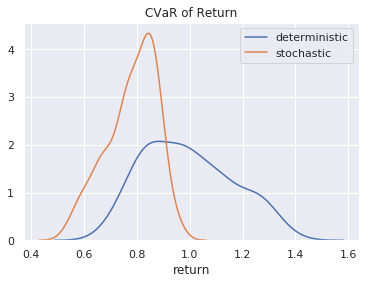

In [97]:
#st_cv = ret_cv
#st_mean = ret_mean
sns.kdeplot(ret_cv, label='deterministic')
sns.kdeplot(st_cv, label='stochastic')
plt.title('CVaR of Return')
plt.xlabel('return')

Text(0.5,0,'return')

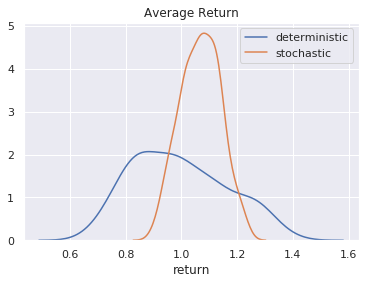

In [96]:
sns.kdeplot(ret_mean, label='deterministic')
sns.kdeplot(st_mean, label='stochastic')
plt.title('Average Return')
plt.xlabel('return')

0.5533346918043969
0.9516742002751399


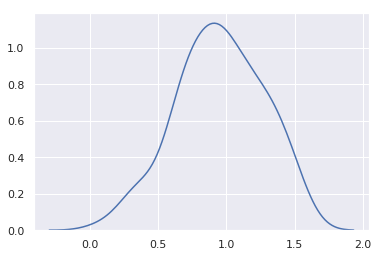

In [86]:
sns.kdeplot(ret_pi)
print(cv(ret_pi, args.alpha))
print(np.mean(ret_pi))

In [87]:
idx = np.argmax(ret_mean)
print(idx)
print(pi[idx][:])
print(np.max(ret_mean))
idx = np.argmax(ret_cv)
print(idx)
print(pi[idx][:])
print(np.max(ret_cv))
print(ret_cv[56])

226
[3, 2, 0, 2]
1.2279255854058886
104
[1, 2, 2, 0]
0.964168567762034
0.8574140411890862


In [18]:
# test to see if it's deterministc

0.46491852080582674


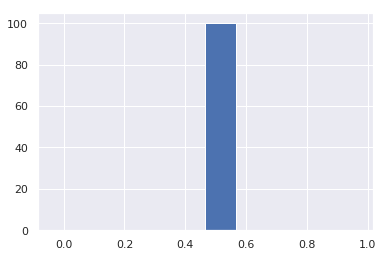

In [9]:
ret_dist = []
pi = [2, 2]
for i in range(100):
    s = env.reset()
    ret = []
    for j in range(2):
        s, r, t, info = env.step(pi[j])
        ret.append(r)
    ret_dist.append(discounted_return(ret, 0.99))
plt.hist(ret_dist)
print(np.mean(ret_dist))

### e-greedy learning of the average

In [2]:
from core import config, drl, replay
import tensorflow as tf
from argparse import Namespace

def discounted_return(returns, gamma):
    ret = 0
    for r in reversed(returns):
        ret = r + gamma * ret
    return ret

/home/ramtin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [114]:
args = Namespace(**{'action_noise': 0, 'drop_p':0, 'action_sigma':0,\
                   'episodeCap': 20, 'num_episode': 6000, 'ifCVaR': False, 'opt': 0,\
                   'save_name': 'egreedy', 'alpha': 0.25, 'gamma': 0.99})
tf.reset_default_graph()
with tf.Session() as sess:
    env = HIVTreatment(args)
    Config = config.config(env, args)
    Config.max_step = env.episodeCap
    
    returns = np.zeros((Config.args.num_episode, 2))
    replay_buffer = replay.Replay(Config, load=False)
    counts = np.ones((1, Config.nA))
    C51 = drl.C51(Config, ifCVaR=Config.args.ifCVaR, memory=replay_buffer)
    saver = tf.train.Saver()
    sess.run(tf.initializers.global_variables())
    print("[*] TF model initialized")

    summary_writer = tf.summary.FileWriter(args.save_name + '/summary', sess.graph)
    C51_loss = []
    train_step = 0
    
    for ep in range(Config.args.num_episode):
        terminal = False
        step = 0
        lr = Config.get_lr(ep)
        epsilon = Config.get_epsilon(ep)
 
        episode_return = []
        observation = env.reset()
        pi = []
        while not terminal:
            if np.random.rand() <= epsilon:
                action_id = np.random.randint(Config.nA)
            else:
                if Config.args.ifCVaR:
                    o = np.expand_dims(observation, axis=0)
                    counts = np.ones((1, Config.nA))
                    distribution = C51.predict(sess, o)
                    values = C51.CVaRopt(distribution, count=counts,\
                                 alpha=Config.args.alpha, N=Config.CVaRSamples, c=args.opt, bonus=0.0)
                else:
                    o = np.expand_dims(observation, axis=0)
                    distribution = C51.predict(sess, o)
                    values = C51.Q(distribution)
                action_id = np.random.choice(np.flatnonzero(values == values.max()))
            next_observation, reward, terminal, info = env.step(action_id)
            pi.append(action_id)
            step += 1
            no = np.expand_dims(next_observation, axis=0)
            next_counts = counts # hack to avoind passing counts
            episode_return.append(reward)
            if step >= Config.max_step:
                terminal = True
                 
            replay_buffer.add(observation, action_id, reward, terminal,\
                                 counts, next_counts)
            # Training:
            l, _ = C51.train(sess=sess, size=Config.train_size, opt=args.opt, learning_rate = lr)
                         
            #if ep%Config.summary_write_episode == 0 and summary is not None:
            #    summary_writer.add_summary(summary, train_step)
            train_step += 1
            if l is not None:
                C51_loss.append(l)
                returns[ep, 1] = l
            observation = next_observation   
        returns[ep, 0] = discounted_return(episode_return, Config.args.gamma)
        if ep%Config.print_episode == 0:
            print("Training.  Episode ep:%3d, Discounted Return = %g, Epsilon = %g, Lr = %g, C51 average loss=%g"\
                         %(ep, returns[ep, 0], epsilon, lr, np.mean(C51_loss)))
        if ep% Config.save_episode == 0:
            save_file = {'ep': ep, 'returns': returns}
            replay_buffer.save(args.save_name)
            pickle_in = open(args.save_name + '.p', 'wb')
            pickle.dump(save_file, pickle_in)
            pickle_in.close()
            saver.save(sess, args.save_name + '.ckpt')

Initialzing the replay buffer
[*] TF model initialized
Training.  Episode ep:  0, Discounted Return = 6.50758, Epsilon = 0.9, Lr = 0.001, C51 average loss=3.80667
Replay buffer saved, name:egreedy.p
Training.  Episode ep:100, Discounted Return = 12.0893, Epsilon = 0.871667, Lr = 0.00097, C51 average loss=2.57689
Training.  Episode ep:200, Discounted Return = 6.89592, Epsilon = 0.843333, Lr = 0.00094, C51 average loss=2.62348
Training.  Episode ep:300, Discounted Return = 9.77344, Epsilon = 0.815, Lr = 0.00091, C51 average loss=2.57397
Training.  Episode ep:400, Discounted Return = 7.61423, Epsilon = 0.786667, Lr = 0.00088, C51 average loss=2.53355
Training.  Episode ep:500, Discounted Return = 7.17879, Epsilon = 0.758333, Lr = 0.00085, C51 average loss=2.49657
Training.  Episode ep:600, Discounted Return = 3.5874, Epsilon = 0.73, Lr = 0.00082, C51 average loss=2.46368
Training.  Episode ep:700, Discounted Return = 6.77362, Epsilon = 0.701667, Lr = 0.00079, C51 average loss=2.43773
Trai

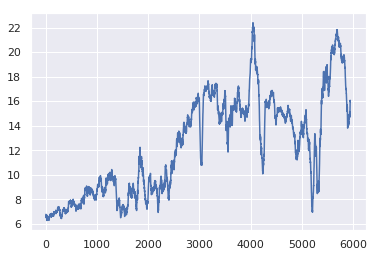

In [128]:
plt.plot(mv(returns[:, 0], 50))

In [14]:
def mv(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

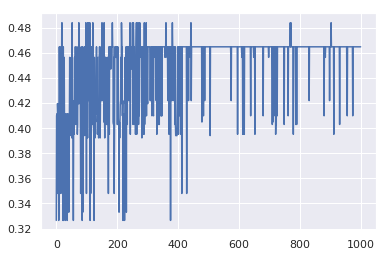

In [8]:
plt.plot(returns[:, 0])

In [26]:
Config.args.gamma

0.99

## Determinisitic Env, with 20 actionable steps and full period

In [24]:
data = pickle.load(open('results/det_exp_test_5000.p', 'rb'))

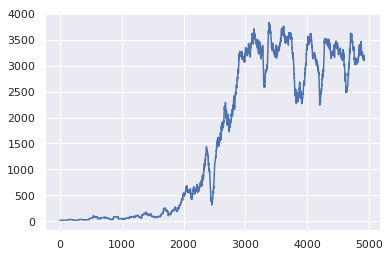

In [27]:
plt.plot(mv(data['returns'][:5000, 0], 75))

In [200]:
## Stochastic Env, with 20 actionable steps and full period, 5 diff stochasticity


In [4]:
def cv(res, alpha=0.25):
    cvar = np.zeros(res.shape[0])
    var = np.sort(res)[int(len(res) * alpha)]
    idx = np.where(res <= var)
    cvar = np.mean(res[idx])
    return cvar

Text(0.5,1,'CVaR s')

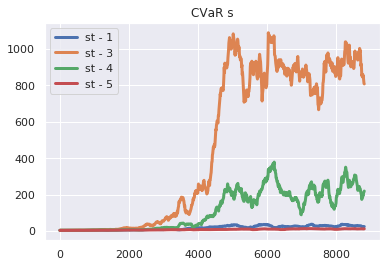

In [58]:
sam = 1000
for ii in [1, 3, 4, 5]:
    data = pickle.load(open('results/st%d_exp_arch3_9000.p'%(ii), 'rb'))
    returns = data['returns'][:9000, 0]
    cv_ret = returns.reshape((sam, -1))
    num = returns.shape[0]
    c = np.zeros((sam))
    for i in range(sam):
        c[i] = cv(cv_ret[i, :])
    ep = np.arange(sam) * num/sam
    plt.plot(ep[:-19], mv(c, 20), label='st - %d'%(ii), linewidth = 3)
plt.legend()
plt.title("CVaR s")

Text(0.5,1,'Retuns')

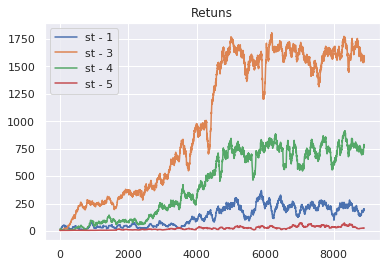

In [256]:
## Stochastic Env, with 20 actionable steps and full period, 5 diff stochasticity
for i in [1, 3, 4, 5]:
    data = pickle.load(open('results/st%d_exp_arch3_9000.p'%(i), 'rb'))

    plt.plot(mv(data['returns'][:9000, 0], 100), label = 'st - %d'%(i))
plt.legend()
plt.title("Retuns")

Now, let's take last 4000 episodes and look at the returns

In [69]:
data = pickle.load(open('results/st3_exp_arch1_9000.p', 'rb'))['returns'][6000:9000, 0]

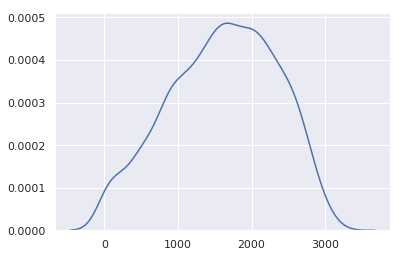

In [70]:
sns.kdeplot(data)

In [72]:
## Let's load the model and see the results

INFO:tensorflow:Restoring parameters from results/st_cvar_20_seed_1.ckpt
[*] TF model restored
New Ep
[0.78567012 0.43838231 0.69824509 0.51251983 0.75427923 0.49078548]


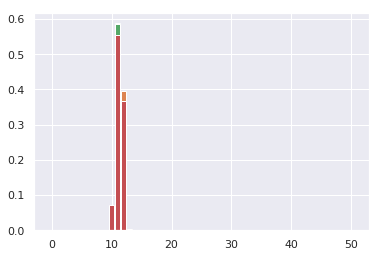

[[0.74 0.8  0.68 0.64]]
[0.82223    0.61192637 0.52990367 0.51391812 0.60083905 0.4872991 ]


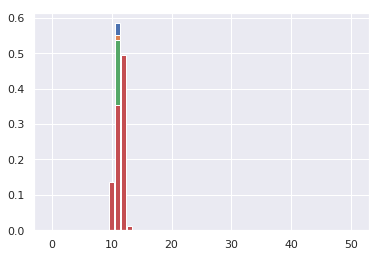

[[0.76 0.86 0.72 0.42]]
[0.83070525 0.47048526 0.67666077 0.5132207  0.73226871 0.51851154]


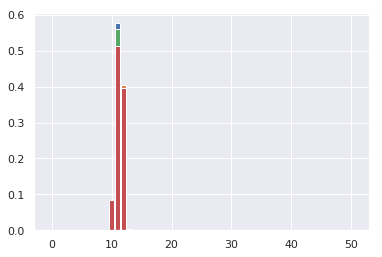

[[0.7  0.84 0.78 0.64]]
[0.82605479 0.48281846 0.66248699 0.51157408 0.7184274  0.49936954]


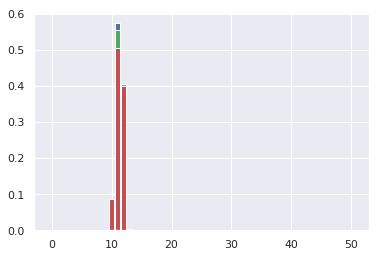

[[0.74 0.8  0.86 0.68]]
[0.80745599 0.44867855 0.70268527 0.51446794 0.74548813 0.51414145]


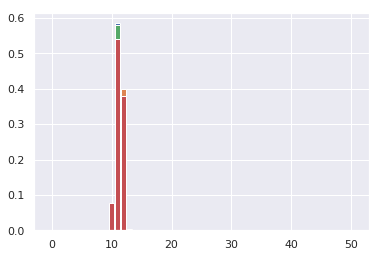

[[0.78 0.78 0.72 0.74]]
[0.82724132 0.56681916 0.58999419 0.52687475 0.6500623  0.56018902]


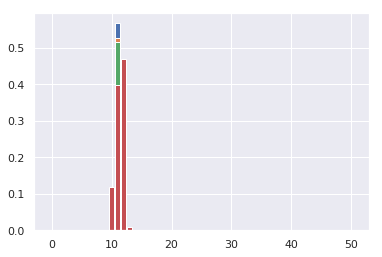

[[0.84 0.82 0.78 0.66]]
[0.77875672 0.41627162 0.72009243 0.51200824 0.77614976 0.53385354]


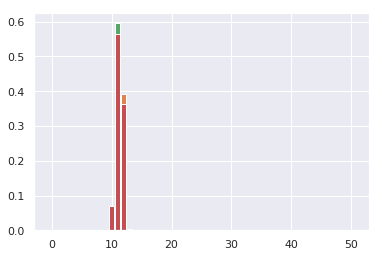

[[0.76 0.76 0.82 0.76]]
[0.79256532 0.44217009 0.70612076 0.51171348 0.74994734 0.51139752]


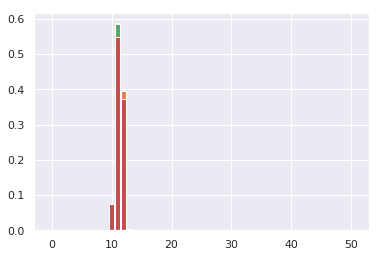

[[0.88 0.78 0.78 0.8 ]]
[0.78482195 0.43889058 0.6979147  0.51207079 0.75370447 0.49344366]


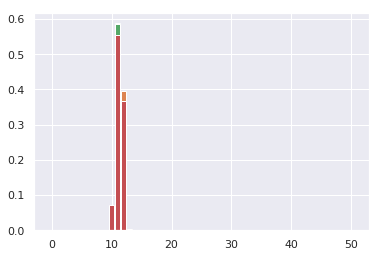

[[0.88 0.86 0.9  0.7 ]]
[0.79421377 0.45655933 0.69160237 0.5115294  0.73542769 0.49356526]


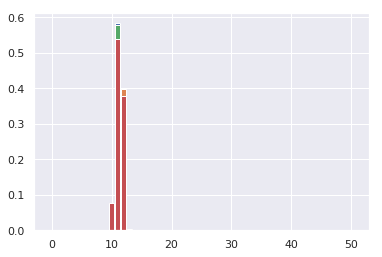

[[0.76 0.92 0.82 0.68]]
[0.82406277 0.59938327 0.56314525 0.53454815 0.63000447 0.50845144]


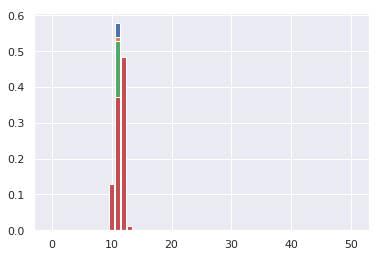

[[0.74 0.7  0.68 0.5 ]]
[0.77917754 0.41627667 0.72011666 0.51205171 0.77614607 0.50652001]


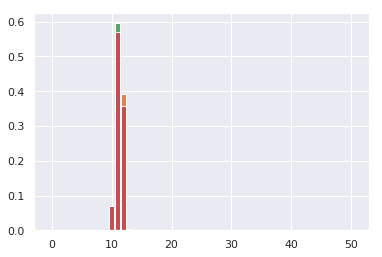

[[0.88 0.78 0.8  0.68]]
[0.78660551 0.44659027 0.69049988 0.51216912 0.7461558  0.49325156]


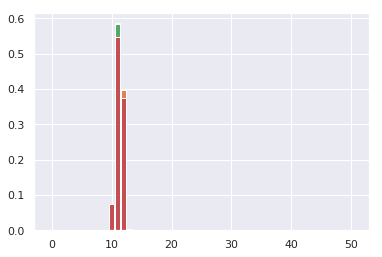

[[0.68 0.82 0.86 0.64]]
[0.79499337 0.45958558 0.68872253 0.51152978 0.73245795 0.49305593]


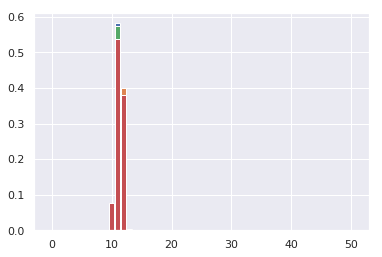

[[0.86 0.78 0.88 0.74]]
[0.79797369 0.45944341 0.68956352 0.51203197 0.73314101 0.49122202]


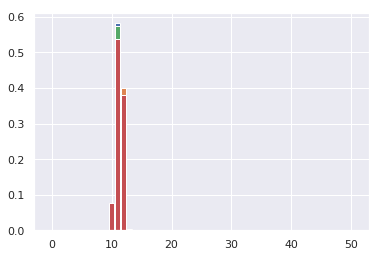

[[0.82 0.72 0.72 0.72]]
[0.783607   0.43535891 0.70130727 0.51202114 0.75714042 0.49045349]


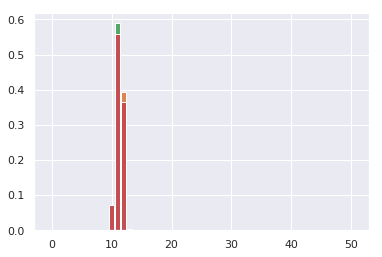

[[0.88 0.76 0.8  0.82]]
[0.78671265 0.44068283 0.69636985 0.5122568  0.75210144 0.49033992]


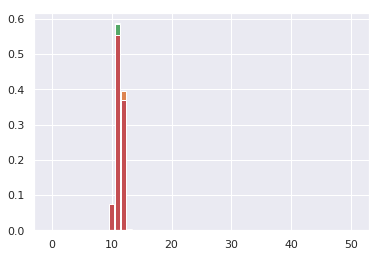

[[0.84 0.78 0.74 0.68]]
[0.78638796 0.43857649 0.69853298 0.51222883 0.75416568 0.49018508]


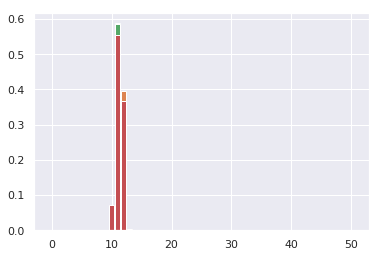

[[0.72 0.7  0.78 0.62]]
[0.79479439 0.45726989 0.69104787 0.51157322 0.73479118 0.4923826 ]


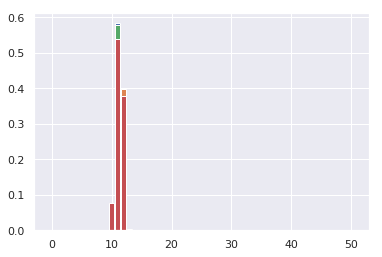

[[0.78 0.76 0.74 0.76]]
[0.78446616 0.43567429 0.70112566 0.51208366 0.75690519 0.49040703]


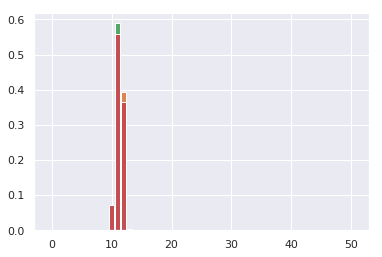

[[0.78 0.84 0.82 0.78]]
0 0.06265297314092372
New Ep
[0.78567012 0.43838231 0.69824509 0.51251983 0.75427923 0.49078548]


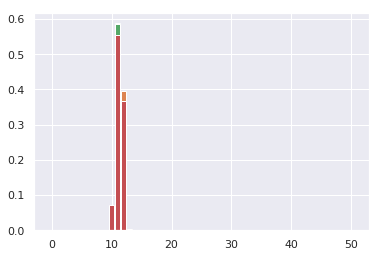

[[0.78 0.82 0.82 0.74]]
[0.82222708 0.61145221 0.53220258 0.51581709 0.60309788 0.48817556]


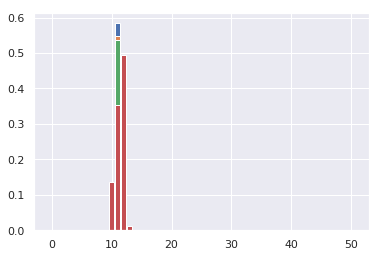

[[0.8  0.62 0.76 0.3 ]]
[0.78004064 0.4148796  0.72166311 0.5121045  0.77759899 0.5010969 ]


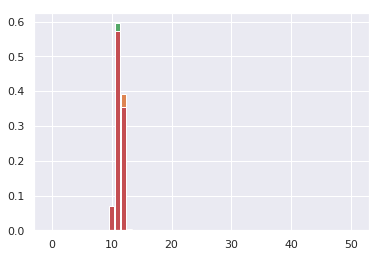

[[0.78 0.78 0.84 0.76]]
[0.79285458 0.44289993 0.7054591  0.51172235 0.7492344  0.49866562]


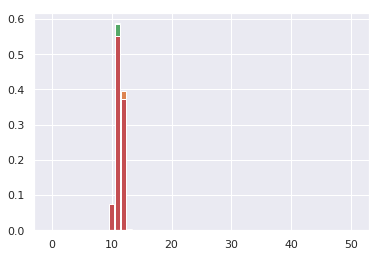

[[0.92 0.82 0.88 0.7 ]]
[0.78466124 0.43872908 0.69802449 0.51206704 0.75383523 0.49121935]


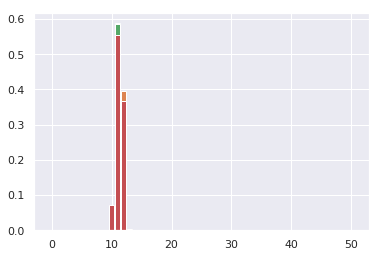

[[0.82 0.76 0.84 0.62]]
[0.79417552 0.45622259 0.69198088 0.51152691 0.73576244 0.4933127 ]


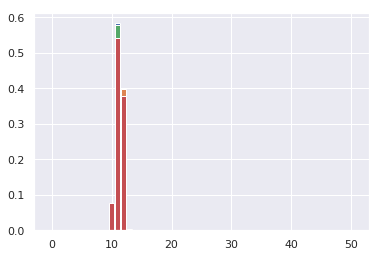

[[0.74 0.78 0.88 0.7 ]]
[0.79763437 0.45913879 0.68979944 0.51196715 0.73338789 0.49125284]


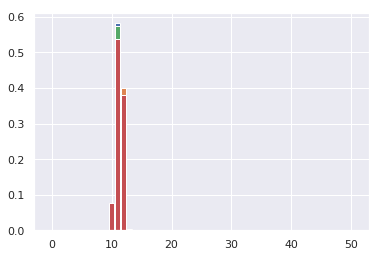

[[0.78 0.82 0.74 0.7 ]]
[0.82488471 0.5921035  0.5723497  0.53652464 0.63733749 0.51799463]


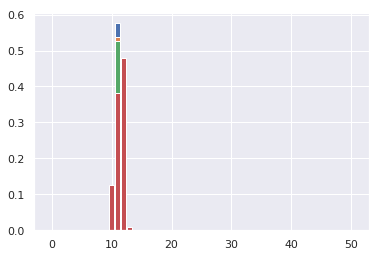

[[0.84 0.72 0.72 0.6 ]]
[0.77906188 0.4163424  0.72004389 0.51204279 0.77608652 0.51012671]


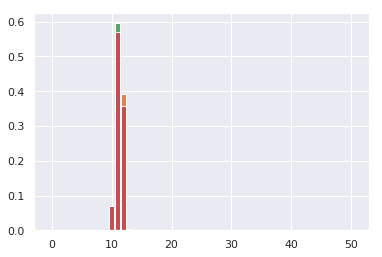

[[0.84 0.8  0.8  0.82]]
[0.7865551  0.44649906 0.6905414  0.51217311 0.7462382  0.49396627]


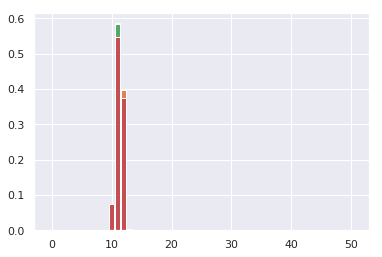

[[0.84 0.74 0.84 0.72]]
[0.78647921 0.43753032 0.69954328 0.51225708 0.75522271 0.49069471]


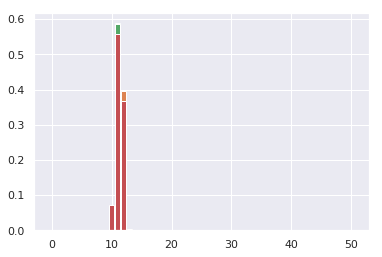

[[0.9  0.84 0.86 0.74]]
[0.78635332 0.4392254  0.69785655 0.51221787 0.75352222 0.49022259]


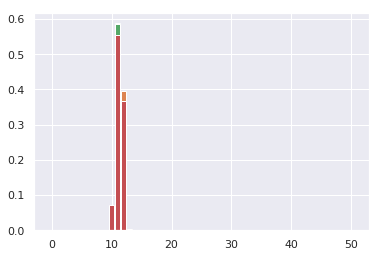

[[0.82 0.76 0.84 0.7 ]]
[0.79479358 0.45744171 0.69086287 0.51156824 0.73461951 0.492417  ]


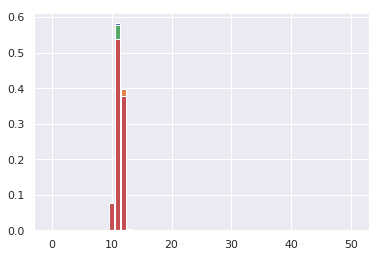

[[0.96 0.76 0.8  0.6 ]]
[0.78437876 0.43567079 0.70109867 0.51208206 0.75688528 0.49041112]


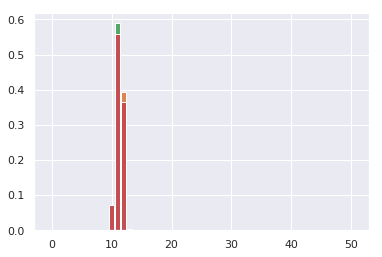

[[0.78 0.82 0.82 0.76]]
[0.79402188 0.45524038 0.69290615 0.51154309 0.73675714 0.49319697]


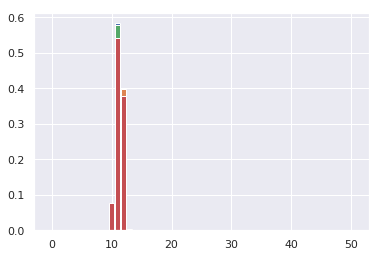

[[0.88 0.8  0.76 0.76]]
[0.78453757 0.43610227 0.70067017 0.51209089 0.7564682  0.49047752]


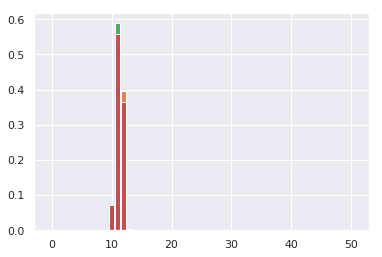

[[0.84 0.68 0.9  0.74]]
[0.7941021  0.45534209 0.69285505 0.51154326 0.73666132 0.49318376]


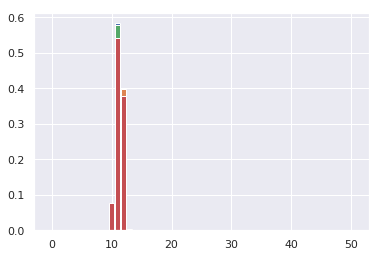

[[0.8  0.8  0.88 0.66]]
[0.79750384 0.45876145 0.69007517 0.51197511 0.7337528  0.49120835]


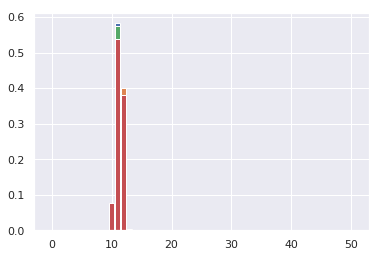

[[0.76 0.68 0.86 0.6 ]]
[0.798548   0.45663675 0.69255078 0.51217686 0.73606187 0.49085412]


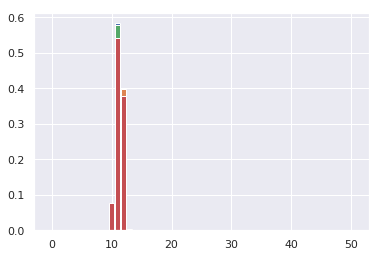

[[0.74 0.86 0.86 0.66]]
[0.8250671  0.58787956 0.57662113 0.53641638 0.64055004 0.52340298]


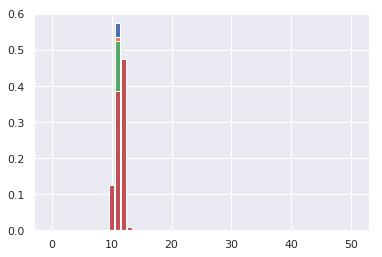

[[0.7  0.76 0.8  0.44]]
1 0.04510981035405549
New Ep
[0.78567012 0.43838231 0.69824509 0.51251983 0.75427923 0.49078548]


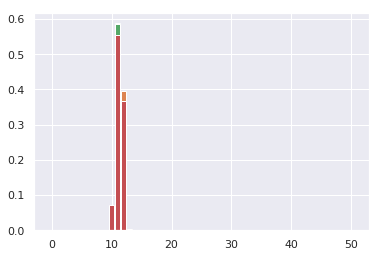

[[0.74 0.74 0.7  0.72]]
[0.82222762 0.61158441 0.53161905 0.5152905  0.60246147 0.48795741]


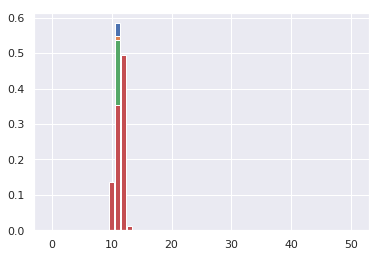

[[0.78 0.58 0.7  0.42]]
[0.78011605 0.41475896 0.72180116 0.51210802 0.77773059 0.50108837]


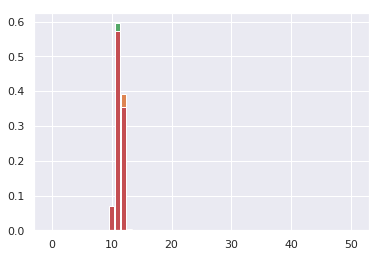

[[0.7  0.82 0.74 0.62]]
[0.82104156 0.61532771 0.49806496 0.48618165 0.57057722 0.4784855 ]


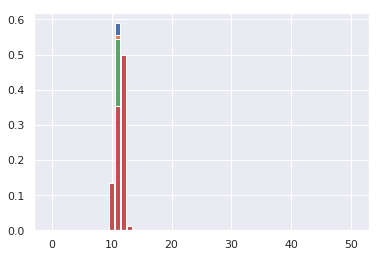

[[0.72 0.72 0.72 0.48]]
[0.80726421 0.47868382 0.67446863 0.51658591 0.71749344 0.50766853]


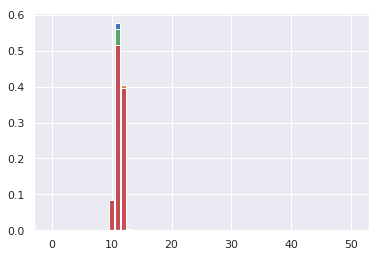

[[0.88 0.78 0.84 0.7 ]]
[0.78127778 0.43238244 0.70400635 0.51190438 0.75997559 0.49485577]


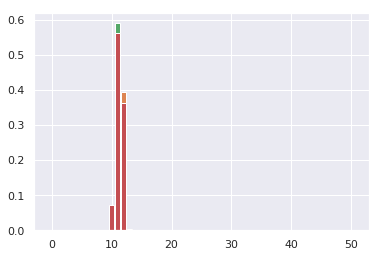

[[0.7  0.8  0.88 0.72]]
[0.79307974 0.45055542 0.69762872 0.5115556  0.74142416 0.49605517]


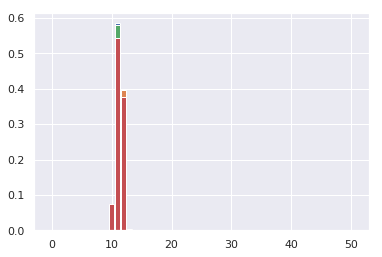

[[0.86 0.86 0.78 0.72]]
[0.78478031 0.43710634 0.6997136  0.51209464 0.75548635 0.49082841]


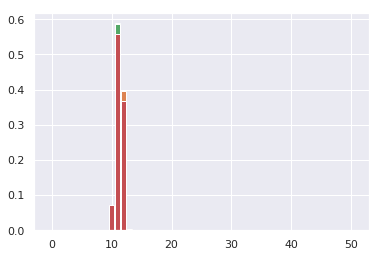

[[0.7  0.84 0.86 0.7 ]]
[0.79421869 0.45566531 0.69258735 0.5115412  0.73634308 0.49319033]


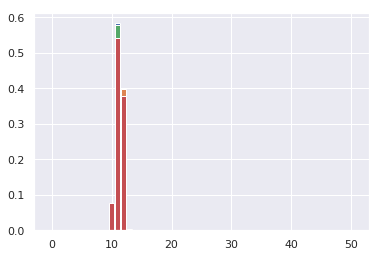

[[0.84 0.78 0.88 0.86]]
[0.7976515  0.45900823 0.6899826  0.51196293 0.73351101 0.49122558]


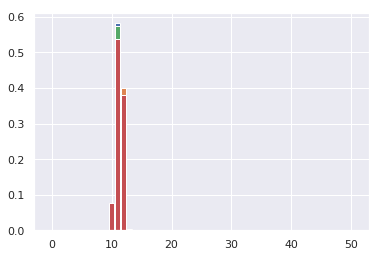

[[0.84 0.76 0.82 0.78]]
[0.78354534 0.43550585 0.70108076 0.51202269 0.75698041 0.49042809]


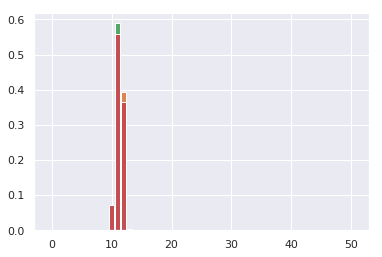

[[0.84 0.68 0.72 0.76]]
[0.78670643 0.44063618 0.69640094 0.51225888 0.75214797 0.49034013]


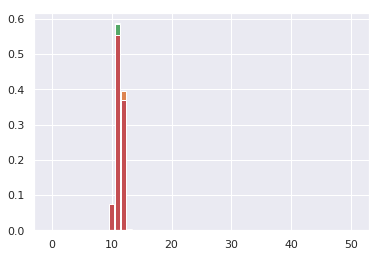

[[0.82 0.82 0.82 0.66]]
[0.7863162  0.43849196 0.69856005 0.51222773 0.75424741 0.49018069]


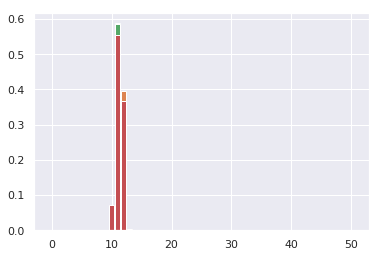

[[0.82 0.88 0.84 0.68]]
[0.82235056 0.61122316 0.53290431 0.51615275 0.6035482  0.48867777]


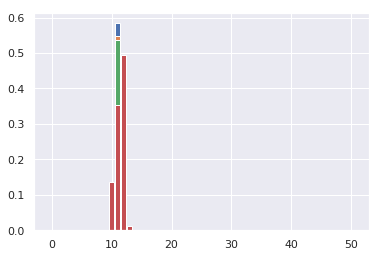

[[0.78 0.66 0.62 0.52]]
[0.78008429 0.41475069 0.72177335 0.5121064  0.7777556  0.50128008]


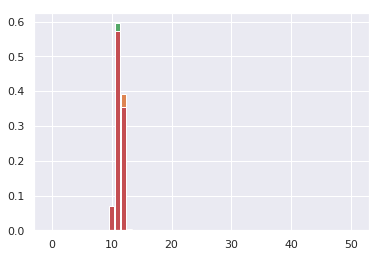

[[0.84 0.84 0.72 0.82]]
[0.78637755 0.44624818 0.690752   0.51215294 0.74647232 0.49224585]


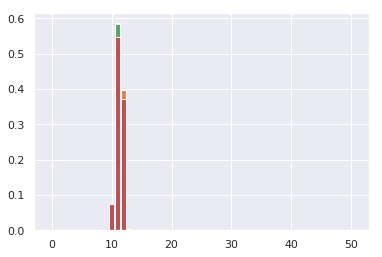

[[0.76 0.76 0.88 0.7 ]]
[0.7948967  0.45944757 0.68886105 0.51152367 0.73256726 0.49296052]


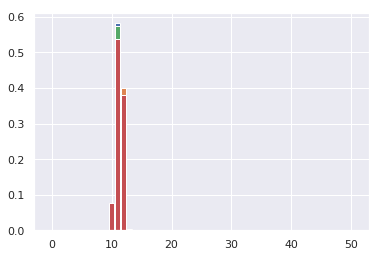

[[0.8  0.8  0.74 0.66]]
[0.78449462 0.43526415 0.701579   0.51208974 0.75731175 0.49049486]


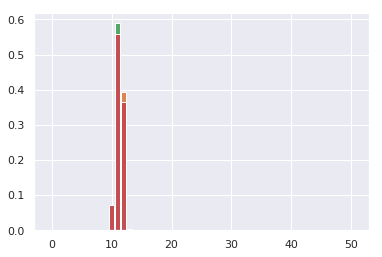

[[0.78 0.82 0.84 0.72]]
[0.79404477 0.45525063 0.69285381 0.51154875 0.7367661  0.4931204 ]


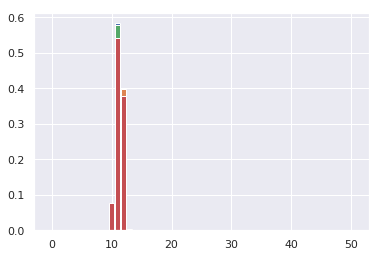

[[0.86 0.78 0.76 0.72]]
[0.78448585 0.43609214 0.7006511  0.51208955 0.75647182 0.49046793]


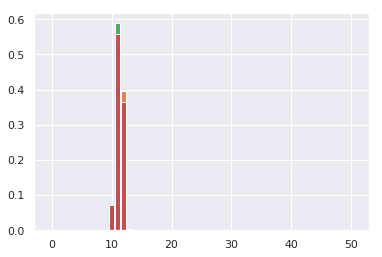

[[0.92 0.82 0.78 0.68]]
2 0.03440722069784657
New Ep
[0.78567012 0.43838231 0.69824509 0.51251983 0.75427923 0.49078548]


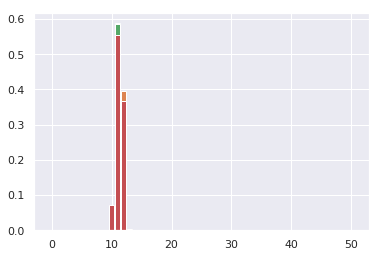

[[0.84 0.78 0.78 0.72]]
[0.78650927 0.43926812 0.69779547 0.51223849 0.75350416 0.49027729]


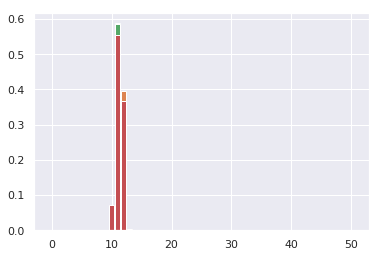

[[0.84 0.86 0.88 0.68]]
[0.79482666 0.4577171  0.69055338 0.51157505 0.73434206 0.49232213]


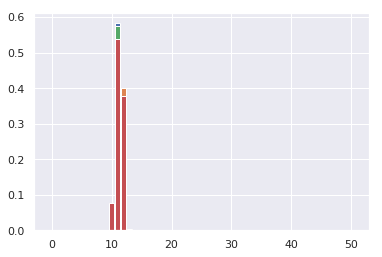

[[0.74 0.8  0.7  0.78]]
[0.82420455 0.59696035 0.56699266 0.53605327 0.63324037 0.5111055 ]


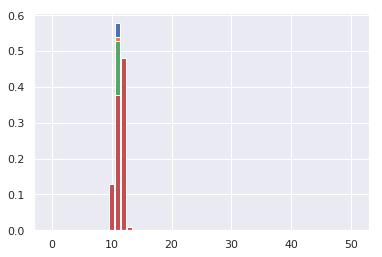

[[0.76 0.76 0.72 0.42]]
[0.82948621 0.45332721 0.69332231 0.51267152 0.74887704 0.51853601]


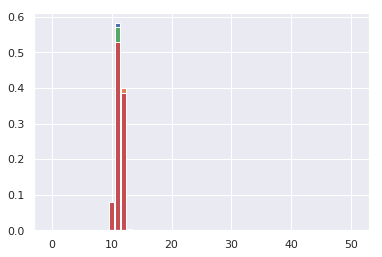

[[0.78 0.76 0.8  0.74]]
[0.80802147 0.44750284 0.7039195  0.51468312 0.74674203 0.52719799]


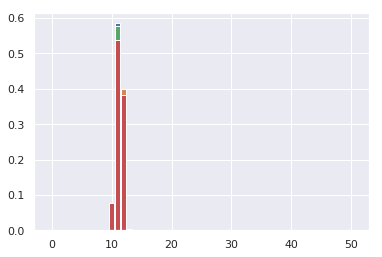

[[0.8  0.8  0.74 0.78]]
[0.82735828 0.56492249 0.59125855 0.52596301 0.65101043 0.56865929]


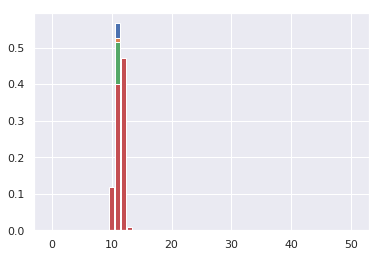

[[0.86 0.6  0.74 0.44]]
[0.77873686 0.41632297 0.72006158 0.51199787 0.77608283 0.53992222]


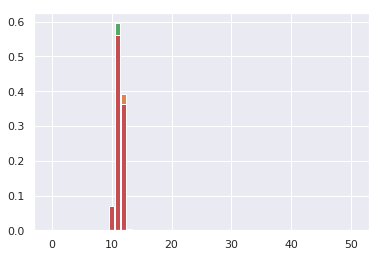

[[0.8  0.86 0.9  0.72]]
[0.79255044 0.44220363 0.70609462 0.51171016 0.74990215 0.51442972]


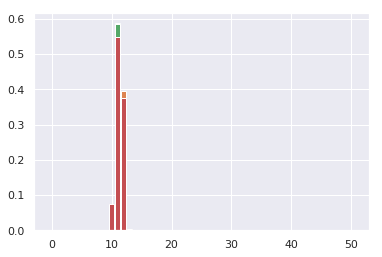

[[0.84 0.74 0.78 0.74]]
[0.78481747 0.43887992 0.69791413 0.51207089 0.75371746 0.49408269]


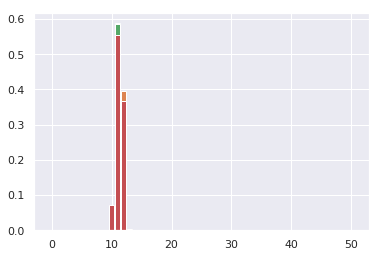

[[0.8  0.84 0.78 0.62]]
[0.82206825 0.61217357 0.52925807 0.5135244  0.60030217 0.48711448]


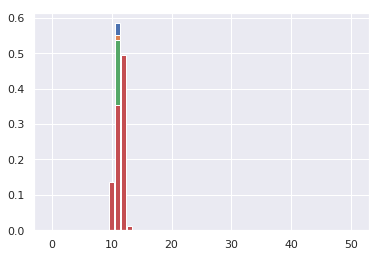

[[0.76 0.68 0.68 0.4 ]]
[0.78004651 0.41482831 0.72168365 0.51210649 0.77765502 0.5008325 ]


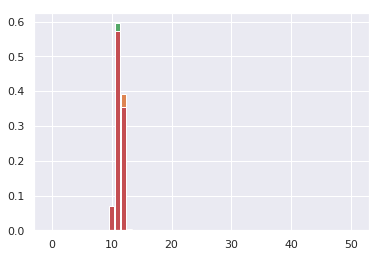

[[0.82 0.88 0.82 0.7 ]]
[0.82102668 0.61499794 0.50191901 0.48967789 0.57439433 0.47945226]


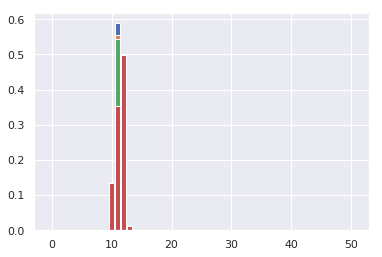

[[0.8  0.72 0.84 0.44]]
[0.80725686 0.47767676 0.67538369 0.51648596 0.71839335 0.50766348]


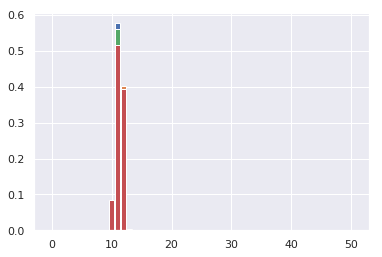

[[0.84 0.78 0.8  0.64]]
[0.78128154 0.43251436 0.70385586 0.51190207 0.75985144 0.49484562]


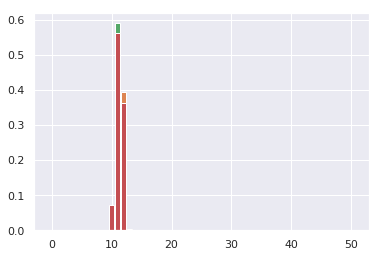

[[0.76 0.92 0.82 0.76]]
[0.82139895 0.61505279 0.50939136 0.49692035 0.58165399 0.47999829]


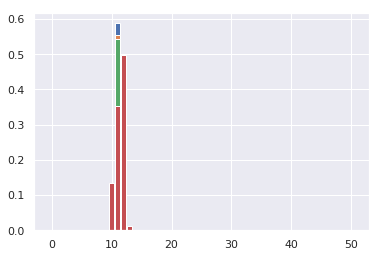

[[0.76 0.74 0.7  0.42]]
[0.78046559 0.41393723 0.72259882 0.5121368  0.77856791 0.49955561]


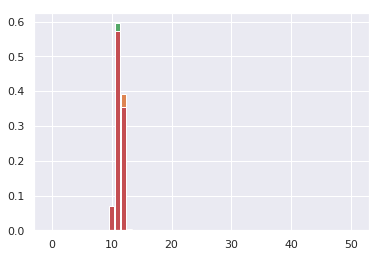

[[0.74 0.84 0.88 0.8 ]]
[0.7928721  0.44328658 0.70504488 0.51172021 0.74883173 0.49790455]


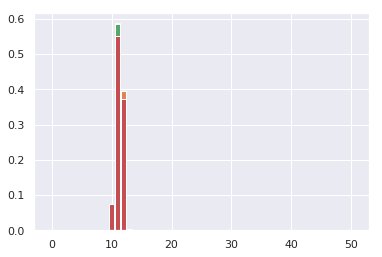

[[0.86 0.84 0.76 0.72]]
[0.78471904 0.43864648 0.69814494 0.51206925 0.75392679 0.49110553]


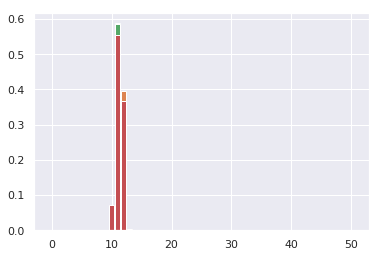

[[0.8 0.7 0.7 0.7]]
[0.78668087 0.43968844 0.69740295 0.51225572 0.75309396 0.49037154]


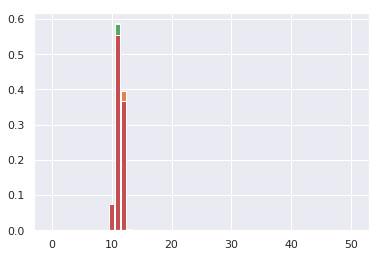

[[0.86 0.72 0.8  0.6 ]]
3 0.07149068293597159
New Ep
[0.78567012 0.43838231 0.69824509 0.51251983 0.75427923 0.49078548]


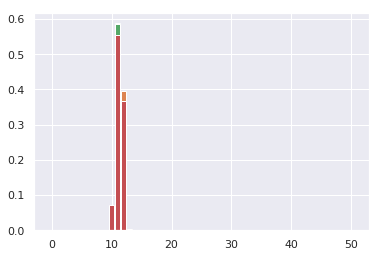

[[0.8  0.86 0.78 0.64]]
[0.82222424 0.61117177 0.53366885 0.51682165 0.60427214 0.48877031]


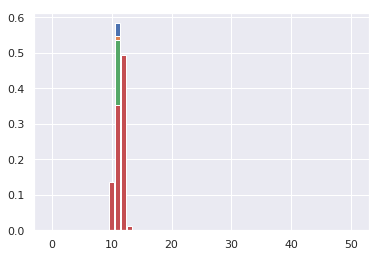

[[0.74 0.68 0.68 0.58]]
[0.78004753 0.41490465 0.72162893 0.5121037  0.77758489 0.50119234]


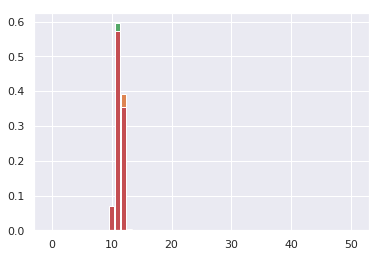

[[0.9  0.84 0.76 0.72]]
[0.78637134 0.44618024 0.69078335 0.51215532 0.74655174 0.49222975]


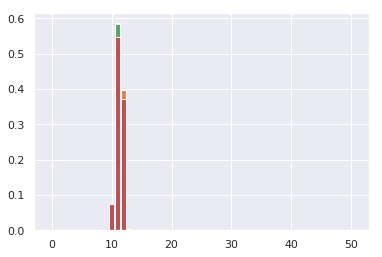

[[0.82 0.82 0.82 0.72]]
[0.79488364 0.45951773 0.6887467  0.51152586 0.73250275 0.49293101]


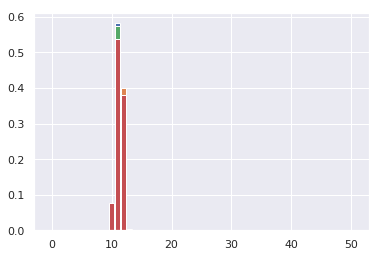

[[0.88 0.84 0.76 0.7 ]]
[0.78450174 0.43522346 0.70160229 0.51209058 0.75736358 0.4904912 ]


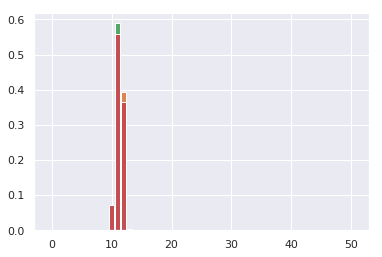

[[0.82 0.7  0.82 0.62]]
[0.79410215 0.45484511 0.69340022 0.51154992 0.73717    0.49323684]


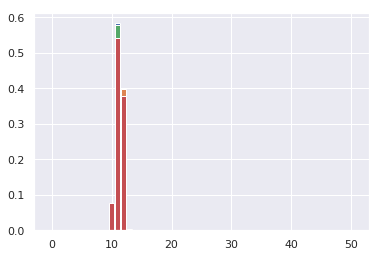

[[0.78 0.76 0.88 0.68]]
[0.79751971 0.45870033 0.69019509 0.51196653 0.73380553 0.49121282]


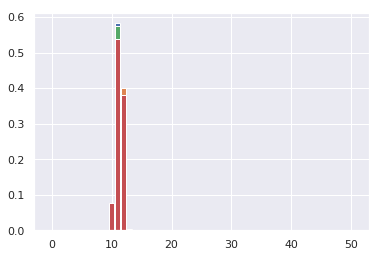

[[0.76 0.8  0.84 0.68]]
[0.79859136 0.45671037 0.69250337 0.51217225 0.73600158 0.49085473]


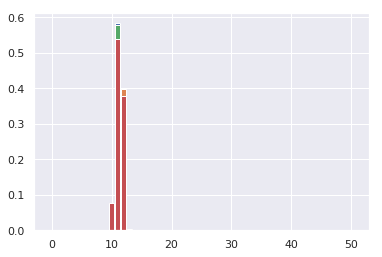

[[0.88 0.8  0.88 0.7 ]]
[0.79867128 0.45473766 0.69445804 0.5122156  0.73801151 0.49077013]


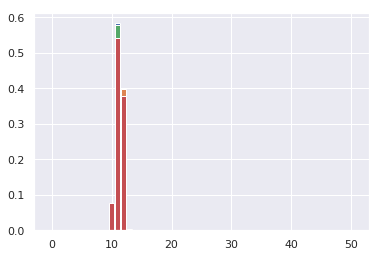

[[0.74 0.82 0.9  0.8 ]]
[0.79847749 0.45388998 0.695257   0.5122124  0.73880582 0.49072642]


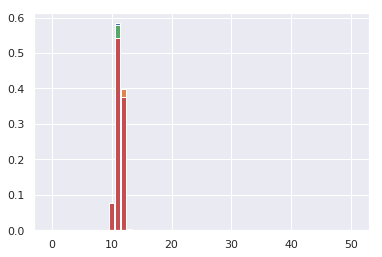

[[0.8  0.78 0.8  0.62]]
[0.78341934 0.43648189 0.70012715 0.5119915  0.75598678 0.49043223]


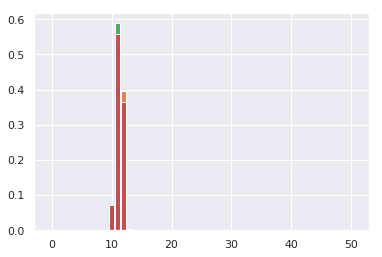

[[0.86 0.86 0.72 0.68]]
[0.78687058 0.44074838 0.69639096 0.5122668  0.75204607 0.49036513]


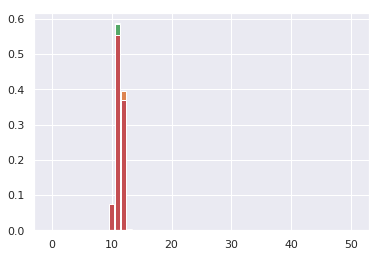

[[0.78 0.82 0.82 0.76]]
[0.82247359 0.61062944 0.53580046 0.51849839 0.6063017  0.48987683]


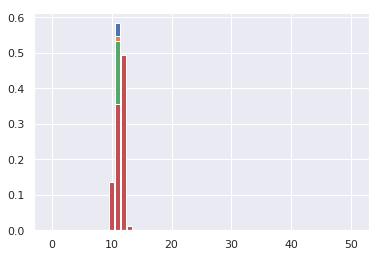

[[0.82 0.8  0.86 0.52]]
[0.80764898 0.47243894 0.68040531 0.51622748 0.72326216 0.51043335]


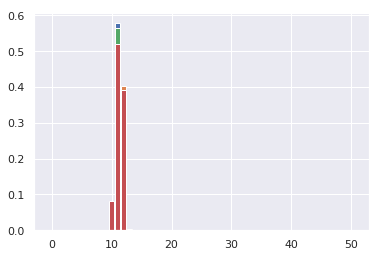

[[0.84 0.74 0.72 0.68]]
[0.78106628 0.43352863 0.70276734 0.51187665 0.75878165 0.4955345 ]


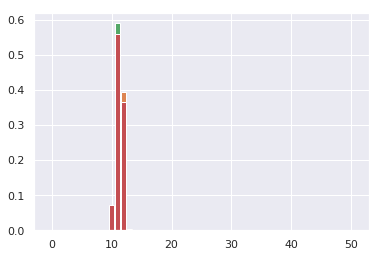

[[0.9  0.82 0.64 0.8 ]]
[0.78715306 0.44262062 0.6945653  0.51228389 0.75020371 0.49121802]


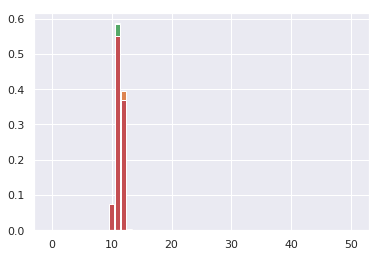

[[0.78 0.78 0.8  0.78]]
[0.79511679 0.45900801 0.68929029 0.51158079 0.73307103 0.49230758]


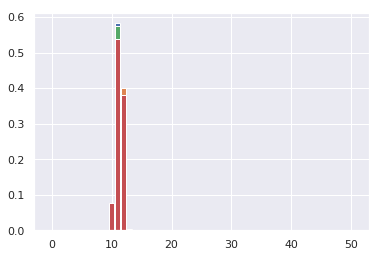

[[0.84 0.86 0.76 0.62]]
[0.82429375 0.59831533 0.56479764 0.53518251 0.63137616 0.50969883]


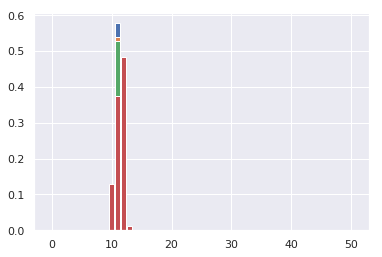

[[0.68 0.7  0.8  0.38]]
[0.80784443 0.46750091 0.68492563 0.51606452 0.72792287 0.517267  ]


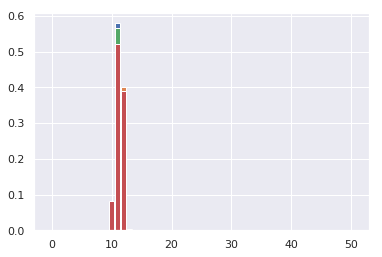

[[0.84 0.66 0.74 0.56]]
4 0.04019544925405184
New Ep
[0.78567012 0.43838231 0.69824509 0.51251983 0.75427923 0.49078548]


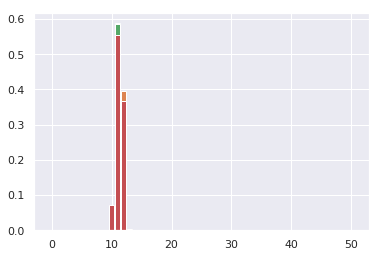

[[0.84 0.74 0.9  0.84]]
[0.79453649 0.45692135 0.69135347 0.51155111 0.7351003  0.49277066]


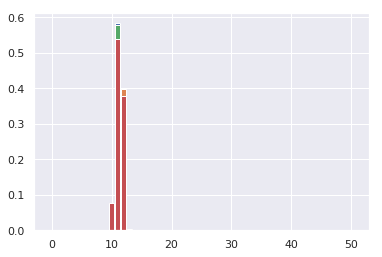

[[0.78 0.82 0.76 0.7 ]]
[0.82414151 0.5990949  0.56341544 0.53464114 0.63031441 0.50870657]


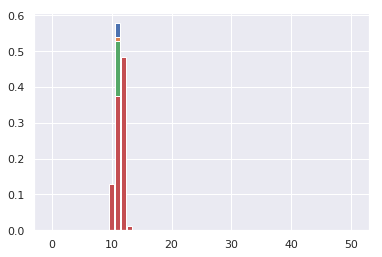

[[0.62 0.64 0.76 0.58]]
[0.80780825 0.46746995 0.68491872 0.51603717 0.72794913 0.51674064]


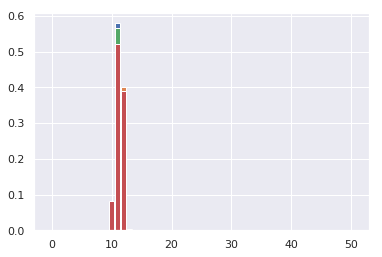

[[0.86 0.82 0.76 0.7 ]]
[0.7811461  0.4340446  0.70230377 0.51186548 0.75827583 0.49707703]


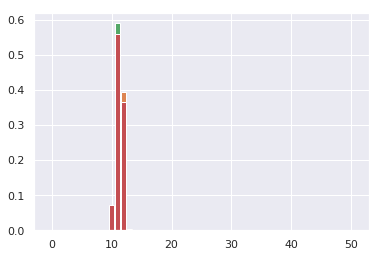

[[0.76 0.76 0.88 0.82]]
[0.79300883 0.45114876 0.69701497 0.51153789 0.7407836  0.49659936]


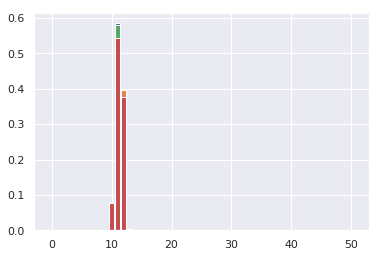

[[0.82 0.74 0.84 0.68]]
[0.79707906 0.45828636 0.69053372 0.51189067 0.73414245 0.49176246]


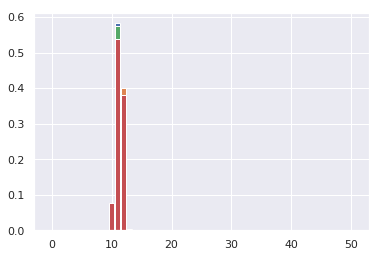

[[0.84 0.7  0.8  0.68]]
[0.78381008 0.43557205 0.70113235 0.51203561 0.75693084 0.4904514 ]


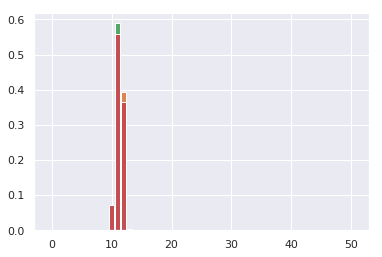

[[0.84 0.84 0.86 0.76]]
[0.79385483 0.45450143 0.69367607 0.5115363  0.73748594 0.49356193]


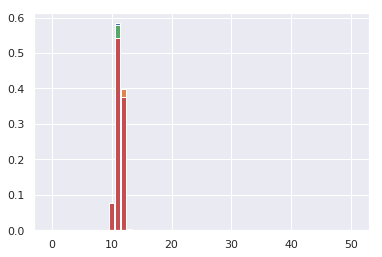

[[0.84 0.82 0.84 0.7 ]]
[0.78464164 0.43625792 0.70055455 0.51209326 0.7563271  0.49051872]


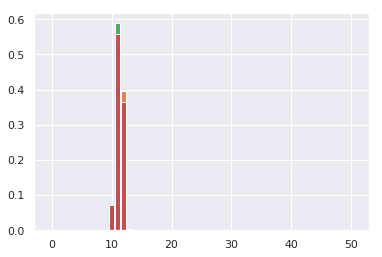

[[0.78 0.84 0.82 0.72]]
[0.82201811 0.61244529 0.52702066 0.51161992 0.59821315 0.48602038]


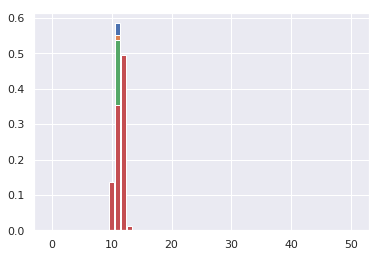

[[0.78 0.78 0.68 0.52]]
[0.83070753 0.471638   0.67556781 0.51326527 0.73114924 0.5186825 ]


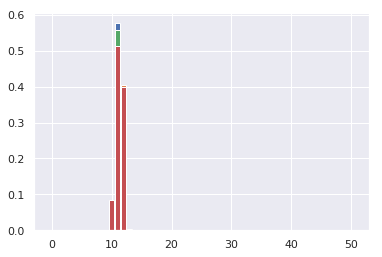

[[0.74 0.64 0.82 0.74]]
[0.80855319 0.45347415 0.69836077 0.51536186 0.74117763 0.52942001]


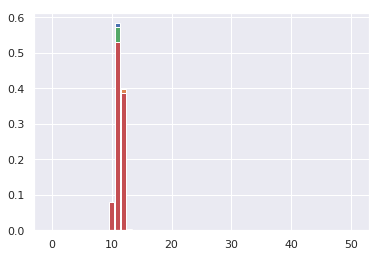

[[0.84 0.86 0.82 0.64]]
[0.82762437 0.56349243 0.59250055 0.52573409 0.65207502 0.57108911]


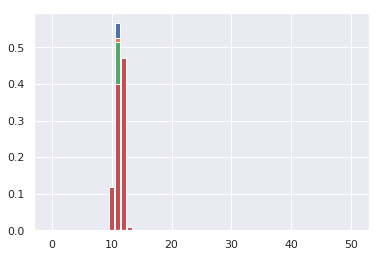

[[0.74 0.76 0.84 0.42]]
[0.808557   0.46889646 0.6839954  0.51673593 0.72686484 0.55590103]


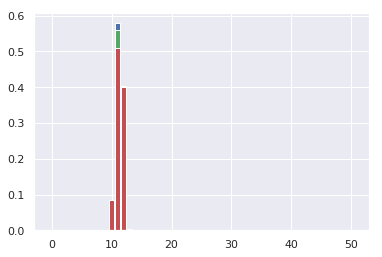

[[0.8  0.82 0.84 0.56]]
[0.80070197 0.44345466 0.70617135 0.51260699 0.74956693 0.51138237]


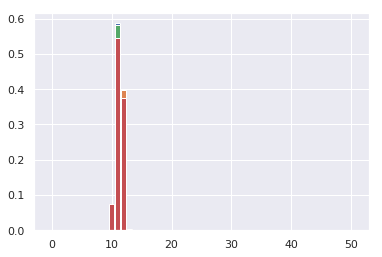

[[0.78 0.84 0.88 0.64]]
[0.79815347 0.44863349 0.70049453 0.51220175 0.74405426 0.49410493]


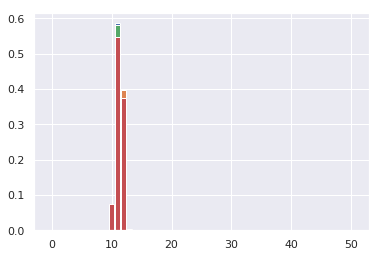

[[0.74 0.72 0.86 0.72]]
[0.7981273  0.45308358 0.69605879 0.51214447 0.73955586 0.49108853]


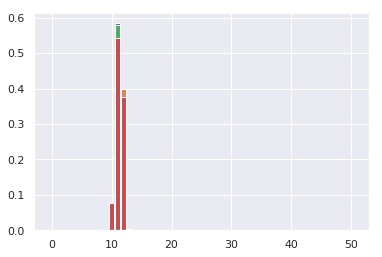

[[0.92 0.86 0.76 0.76]]
[0.78350639 0.43663463 0.69998751 0.5119959  0.75583993 0.49044679]


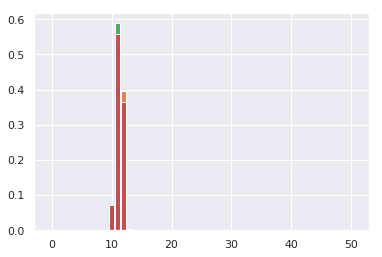

[[0.92 0.74 0.8  0.7 ]]
[0.78680066 0.44057585 0.69652008 0.51226582 0.75221103 0.49035615]


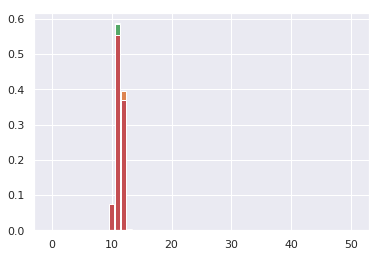

[[0.74 0.76 0.78 0.66]]
5 0.08160549709339066
New Ep
[0.78567012 0.43838231 0.69824509 0.51251983 0.75427923 0.49078548]


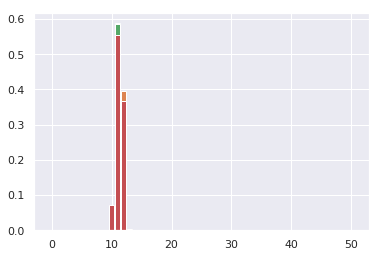

[[0.86 0.8  0.8  0.66]]
[0.78647646 0.43925287 0.69781582 0.51223805 0.75350189 0.490275  ]


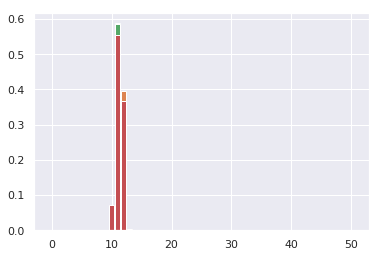

[[0.78 0.76 0.8  0.68]]
[0.79480383 0.45777248 0.69048386 0.511575   0.7342772  0.49231441]


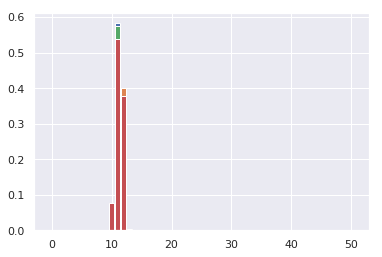

[[0.76 0.78 0.86 0.68]]
[0.7979041  0.45921128 0.68982468 0.51200465 0.73336056 0.49110275]


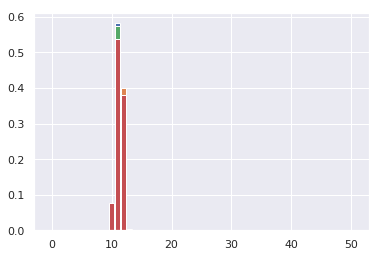

[[0.88 0.76 0.68 0.7 ]]
[0.78356189 0.43543175 0.70118923 0.51202017 0.75706428 0.49043273]


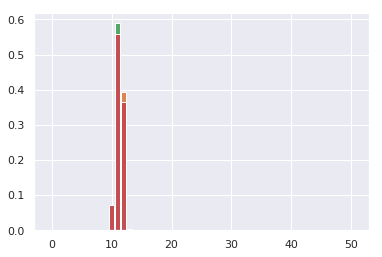

[[0.84 0.78 0.7  0.66]]
[0.78679749 0.44082367 0.69629681 0.51225855 0.75196275 0.49034756]


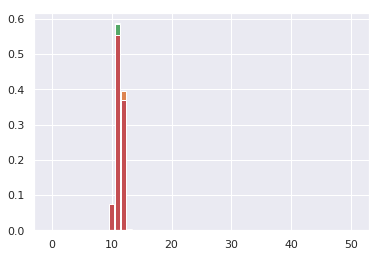

[[0.86 0.84 0.82 0.7 ]]
[0.78631454 0.43846666 0.69860617 0.51222669 0.7542661  0.49017903]


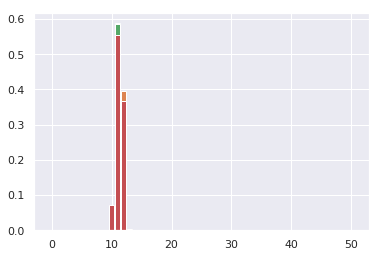

[[0.9  0.82 0.78 0.82]]
[0.78619193 0.4388797  0.69808133 0.51222266 0.75384086 0.49015841]


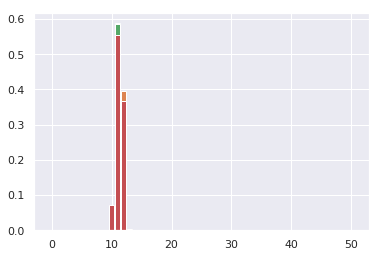

[[0.84 0.86 0.76 0.74]]
[0.82232843 0.61107898 0.53375854 0.51689922 0.60440975 0.48891369]


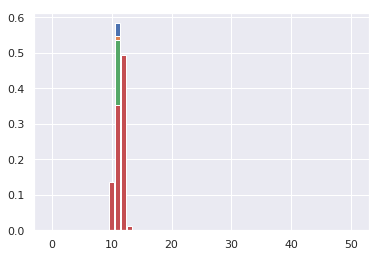

[[0.78 0.7  0.78 0.36]]
[0.80757274 0.47211549 0.6806209  0.51618016 0.7235564  0.51007474]


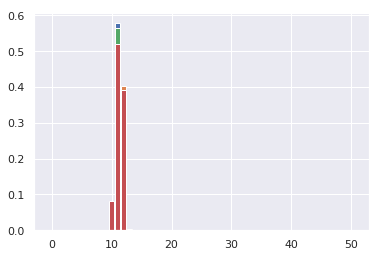

[[0.88 0.74 0.76 0.7 ]]
[0.7811501  0.43347972 0.70287826 0.51187953 0.75883373 0.49542908]


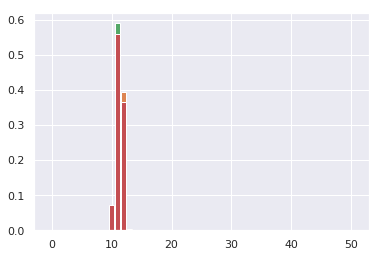

[[0.8  0.9  0.82 0.68]]
[0.82138634 0.61542091 0.50635732 0.49439608 0.5788513  0.47910276]


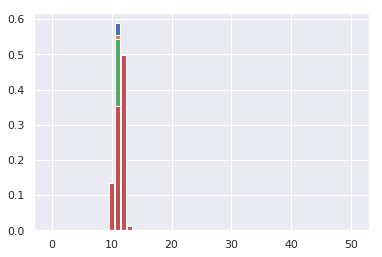

[[0.82 0.76 0.74 0.5 ]]
[0.78075654 0.4135303  0.72307331 0.51215025 0.77900859 0.49952445]


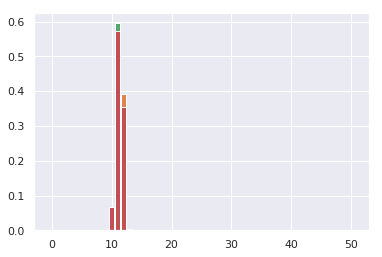

[[0.82 0.74 0.82 0.72]]
[0.78619437 0.44605931 0.69087876 0.51213949 0.74663457 0.49191953]


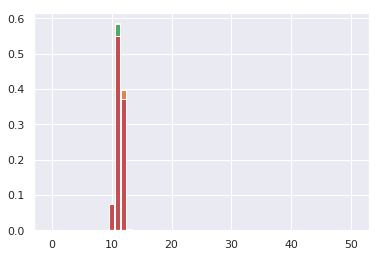

[[0.84 0.76 0.7  0.72]]
[0.78672751 0.43794072 0.6992214  0.51226615 0.75485557 0.49045958]


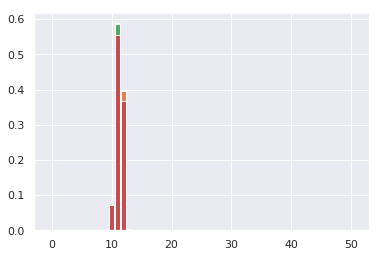

[[0.88 0.86 0.78 0.72]]
[0.7862371  0.43900758 0.69804259 0.5122139  0.75371601 0.49018003]


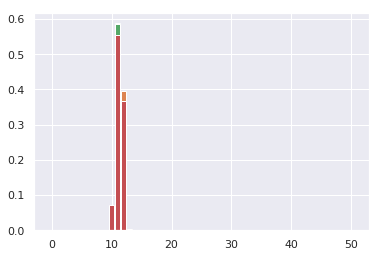

[[0.78 0.78 0.76 0.7 ]]
[0.7864067  0.43901045 0.69806272 0.51222926 0.75374171 0.49017654]


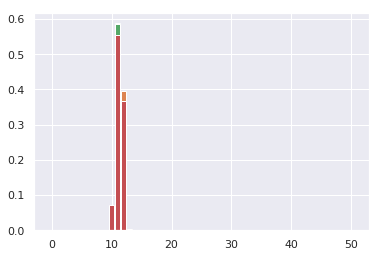

[[0.74 0.8  0.88 0.82]]
[0.79479775 0.4574864  0.6907941  0.51157226 0.73457774 0.49236298]


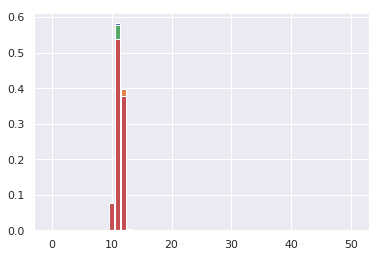

[[0.86 0.74 0.72 0.66]]
[0.78446158 0.43562236 0.70117101 0.51208434 0.75695862 0.49040557]


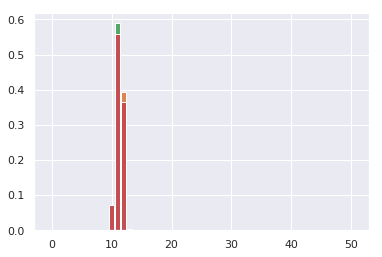

[[0.82 0.74 0.84 0.72]]
[0.7940964  0.45493964 0.69333431 0.51154583 0.73705792 0.49325859]


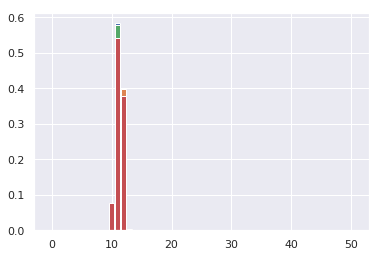

[[0.88 0.9  0.76 0.78]]
6 0.035089878943534374
New Ep
[0.78567012 0.43838231 0.69824509 0.51251983 0.75427923 0.49078548]


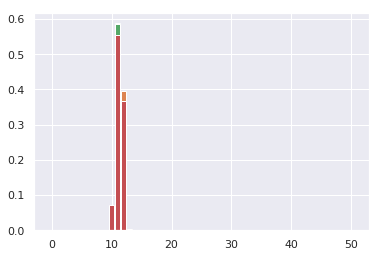

[[0.82 0.74 0.84 0.68]]
[0.79454691 0.45683759 0.69145517 0.51155074 0.73518904 0.49279265]


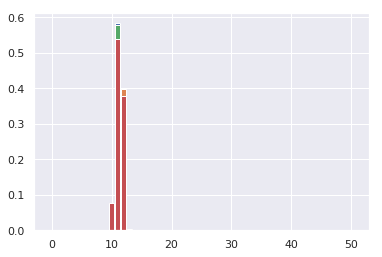

[[0.78 0.86 0.76 0.68]]
[0.82414162 0.59891555 0.56376491 0.53474527 0.63053943 0.50898113]


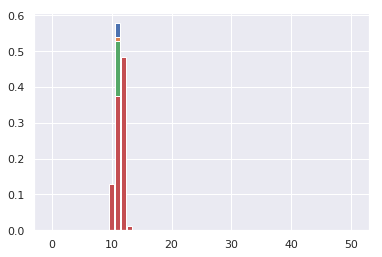

[[0.78 0.68 0.62 0.42]]
[0.77924784 0.41613054 0.72027428 0.51205472 0.7763119  0.50675835]


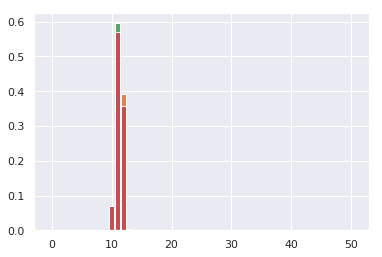

[[0.88 0.78 0.88 0.78]]
[0.79259975 0.44298196 0.70527711 0.5117079  0.74911666 0.50058518]


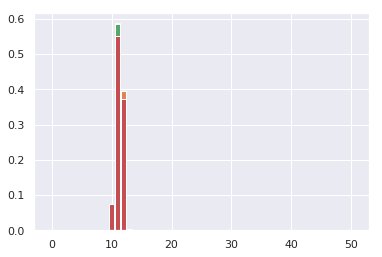

[[0.78 0.74 0.76 0.7 ]]
[0.7848431  0.43872958 0.69810844 0.5120745  0.75386025 0.49150479]


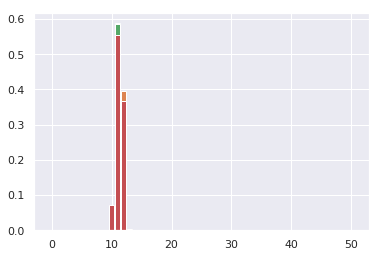

[[0.82 0.66 0.74 0.86]]
[0.82219206 0.62033559 0.26068565 0.2520735  0.3230774  0.4640142 ]


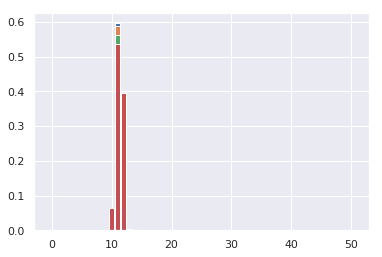

[[0.76 0.78 0.84 0.66]]
[0.80488792 0.52778043 0.6294855  0.51924837 0.67348508 0.51099034]


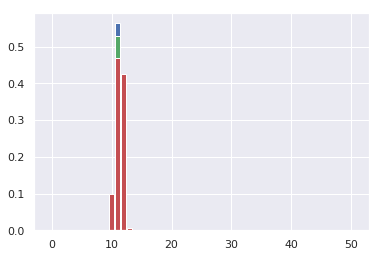

[[0.84 0.74 0.74 0.58]]
[0.78221404 0.42552189 0.71104338 0.51207025 0.76696271 0.49583272]


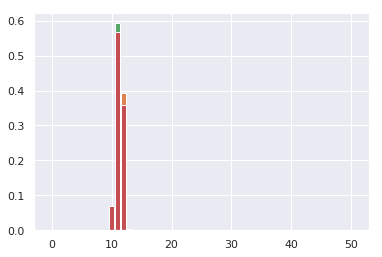

[[0.92 0.82 0.76 0.76]]
[0.786648   0.44323688 0.69382765 0.51221647 0.74953772 0.4911405 ]


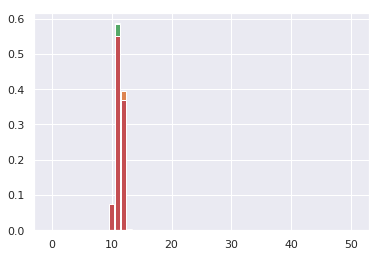

[[0.88 0.82 0.78 0.74]]
[0.78635749 0.43799564 0.69902146 0.51224018 0.75476014 0.49029652]


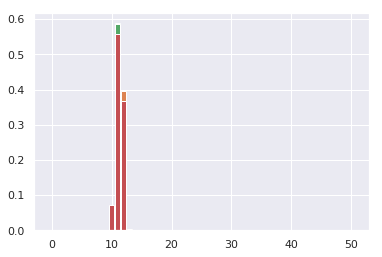

[[0.84 0.78 0.88 0.66]]
[0.79478667 0.45702647 0.69131946 0.51157431 0.73503605 0.4924233 ]


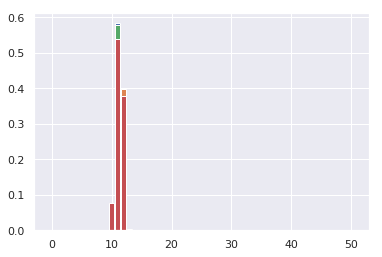

[[0.82 0.68 0.72 0.74]]
[0.78449914 0.43572799 0.70109568 0.51208365 0.75685349 0.49041125]


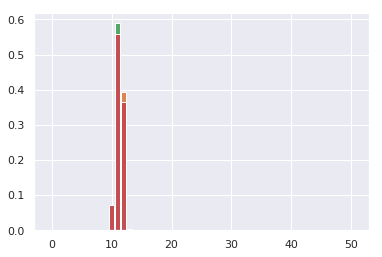

[[0.84 0.9  0.76 0.72]]
[0.82199095 0.61297051 0.52385746 0.50900809 0.5952144  0.48486547]


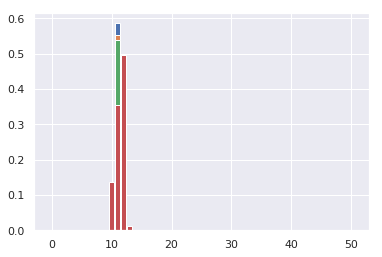

[[0.68 0.66 0.72 0.38]]
[0.80754309 0.47432181 0.67861612 0.51632999 0.721518   0.50920229]


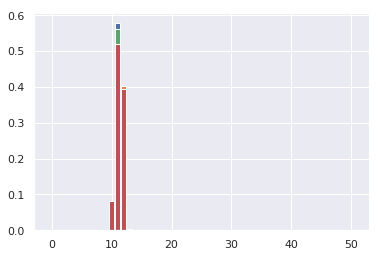

[[0.72 0.76 0.74 0.74]]
[0.82759866 0.56232948 0.59514419 0.52777478 0.65457003 0.55871281]


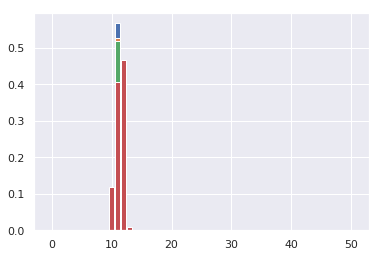

[[0.6  0.64 0.82 0.46]]
[0.80848683 0.46756671 0.68515589 0.51659001 0.72807166 0.54682142]


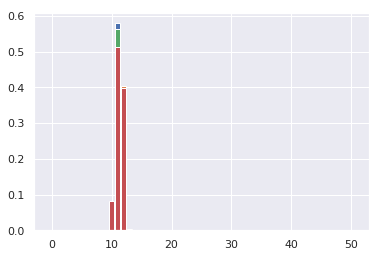

[[0.78 0.84 0.74 0.72]]
[0.82779398 0.56066881 0.59555489 0.52605215 0.65480081 0.58471986]


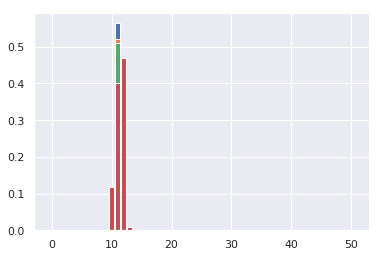

[[0.76 0.82 0.68 0.52]]
[0.8267719  0.44418953 0.7019     0.5121296  0.75758506 0.55271314]


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [47]:
from utils.hiv_env import *

args = Namespace(**{'action_noise': 0, 'drop_p':0, 'action_sigma':0,\
                   'episodeCap': 20, 'num_episode': 5000, 'ifCVaR': False, 'opt': 0,\
                   'save_name': 'ssss', 'alpha': 0.25, 'gamma': 0.99,\
                    'load_name': 'results/st_cvar_20_seed_1',\
                   'arch': 2, 'st': 3, 'seed': 1, 'actionable_time_steps': 20, 'normalize_state' : True,\
                   'normalize_reward': True})
tf.reset_default_graph()
with tf.Session() as sess:
    env = HIVTreatment(args)
    Config = config.config(env, args)
    Config.max_step = env.episodeCap
    
    load_file = pickle.load(open(args.load_name + '_20000.p', 'rb'))
    counts = np.ones((1, Config.nA))
    C51 = drl.C51(Config, ifCVaR=Config.args.ifCVaR, memory=None)
    returns = load_file["returns"]
    initial_ep = load_file["ep"]
    saver = tf.train.Saver()
    saver.restore(sess, args.load_name + '.ckpt')
    print("[*] TF model restored")
    
    tot_return = []
    for ep in range(10):
        terminal = False
        step = 0
        lr = Config.get_lr(ep)
        epsilon = Config.get_epsilon(ep)
 
        episode_return = []
        observation = env.reset()
        pi = []
        print('New Ep')
        while not terminal:
            o = np.expand_dims(observation, axis=0)
            counts = np.ones((1, Config.nA))
            distribution = C51.predict(sess, o)
            values = C51.CVaRopt(distribution, count=counts,\
                         alpha=Config.args.alpha, N=Config.CVaRSamples, c=args.opt, bonus=0.0)
               
            #print(observation)
            #o = np.expand_dims(observation, axis=0)
            #distribution = C51.predict(sess, o)
            #plt.bar(np.arange(51), distribution[0][0, :])
            #plt.bar(np.arange(51), distribution[1][0, :])
            #plt.bar(np.arange(51), distribution[2][0, :])
            #plt.bar(np.arange(51), distribution[3][0, :])
            #plt.show()
            #values = C51.Q(distribution)
            #print(values)
            action_id = np.random.choice(np.flatnonzero(values == values.max()))
            next_observation, reward, terminal, info = env.step(action_id)
            pi.append(action_id)
            step += 1
            no = np.expand_dims(next_observation, axis=0)
            next_counts = counts # hack to avoind passing counts
            episode_return.append(reward)
            if step >= Config.max_step:
                terminal = True
                 
            observation = next_observation   
        tot_return.append(discounted_return(episode_return, Config.args.gamma))
        print(ep, discounted_return(episode_return, Config.args.gamma))

(array([4., 1., 1., 1., 0., 1., 1., 0., 0., 1.]),
 array([0.03198053, 0.03279757, 0.03361461, 0.03443165, 0.03524868,
        0.03606572, 0.03688276, 0.0376998 , 0.03851684, 0.03933388,
        0.04015091]),
 <a list of 10 Patch objects>)

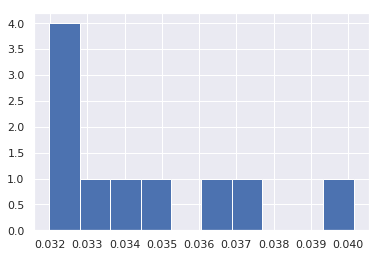

In [43]:
#Bad_retunr = tot_return
#Good_Return = tot_return
plt.hist(tot_return)
#plt.figure()
#sns.kdeplot(Good_Return)

In [48]:
tot_return

[0.06265297314092372,
 0.04510981035405549,
 0.03440722069784657,
 0.07149068293597159,
 0.04019544925405184,
 0.08160549709339066,
 0.035089878943534374]

So it does make sense, now let's see if CVaR learning would do something

## Testing E-greedy
actionable time steps 100

In [3]:
def cv(res, alpha=0.25):
    cvar = np.zeros(res.shape[0])
    var = np.sort(res)[int(len(res) * alpha)]
    idx = np.where(res <= var)
    cvar = np.mean(res[idx])
    return cvar

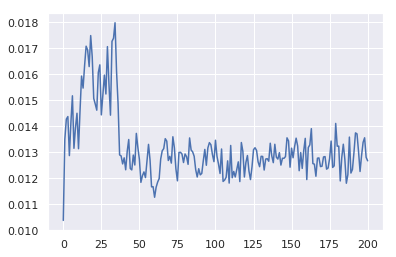

In [195]:
data = pickle.load(open('results/st_cvar_seed_%d_20000.p'%(1), 'rb'))
cvar = np.zeros(data['evaluation_returns'].shape[0])
for j in range(data['evaluation_returns'].shape[0]):
    cvar[j] = cv(data['evaluation_returns'][j, :])
res = cvar

for i in range(2,4):
    data = pickle.load(open('results/st_cvar_seed_%d_20000.p'%(i), 'rb'))
    cvar = np.zeros(data['evaluation_returns'].shape[0])
    for j in range(data['evaluation_returns'].shape[0]):
        cvar[j] = cv(data['evaluation_returns'][j, :])
    res += cvar
res /= 4
plt.plot(res)

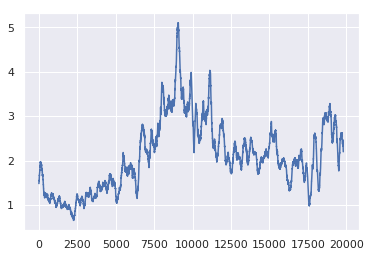

In [264]:
data = pickle.load(open('results/st_exp_seed1_20000.p', 'rb'))
res = mv(data['returns'][:, 0], 200)
for i in range(2,5):
    data = pickle.load(open('results/st_exp_seed%d_20000.p'%(i), 'rb'))
    res += mv(data['returns'][:, 0], 200)
res /= 5
plt.plot(res)

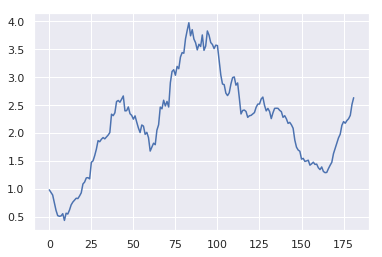

In [191]:
data = pickle.load(open('results/st_exp_seed1_20000.p', 'rb'))
res = mv(np.mean(data['evaluation_returns'], axis = 1), 20)
for i in range(2,5):
    data = pickle.load(open('results/st_exp_seed%d_20000.p'%(i), 'rb'))
    res += mv(np.mean(data['evaluation_returns'], axis = 1), 20)
res /= 5
plt.plot(res)

This seems like the amount of stochasticty is high

In [201]:
#Loweing the actioable steps

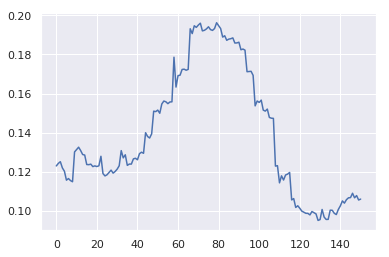

In [295]:
data = pickle.load(open('results/st_cvar_20_seed_1_2500.p', 'rb'))
res = mv(data['returns'][:200, 0], 50)
#plt.plot(res)

## Checking again
Actionable steps 20, exectation, stochasticity small

In [ ]:
data = pickle.load(open('results/st_exp_20_seed%d_20000.p'%(1), 'rb'))
res = mv(data['returns'][:20000, 0], 10)
for i in [2, 3, 4]:
    data = pickle.load(open('results/st_exp_20_seed%d_20000.p'%(i), 'rb'))
    res += mv(data['returns'][:20000, 0], 10)
res /= 4
plt.plot(res, label = 'return')
plt.legend()
plt.title("Retuns")

Text(0.5,1,'Retuns')

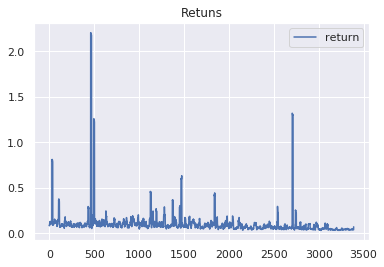

In [84]:
data = pickle.load(open('results/st_cvar_20_seed_%d_3400.p'%(1), 'rb'))
res = mv(data['returns'][:3400, 0], 10)
plt.plot(res, label = 'return')
plt.legend()
plt.title("Retuns")

Text(0.5,1,'Retuns')

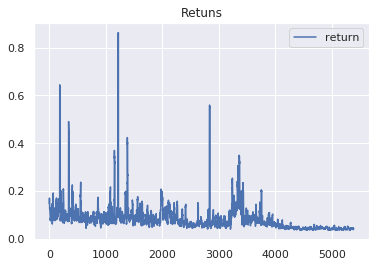

In [85]:
data = pickle.load(open('results/st_cvar_20_05_seed_%d_5400.p'%(1), 'rb'))
res = mv(data['returns'][:5400, 0], 10)
plt.plot(res, label = 'return')
plt.legend()
plt.title("Retuns")

### Lets Look at the CVaR learnig

In [ ]:
from utils.hiv_env import *

args = Namespace(**{'action_noise': 0, 'drop_p':0, 'action_sigma':0,\
                   'episodeCap': 20, 'num_episode': 10000, 'ifCVaR': True, 'opt': 0,\
                   'save_name': 'egreedy', 'alpha': 0.99, 'gamma': 0.99, 'load_name': 'results/st3_exp_arch1',\
                   'arch': 1, 'st': 3, 'seed': 1, 'actionable_time_steps': 20, 'normalize_state' : True,\
                   'normalize_reward': True})
tf.reset_default_graph()
with tf.Session() as sess:
    env = HIVTreatment(args)
    Config = config.config(env, args)
    Config.max_step = env.episodeCap
    
    returns = np.zeros((Config.args.num_episode, 2))
    replay_buffer = replay.Replay(Config, load=False)
    counts = np.ones((1, Config.nA))
    C51 = drl.C51(Config, ifCVaR=Config.args.ifCVaR, memory=replay_buffer)
    saver = tf.train.Saver()
    sess.run(tf.initializers.global_variables())
    print("[*] TF model initialized")

    summary_writer = tf.summary.FileWriter(args.save_name + '/summary', sess.graph)
    C51_loss = []
    train_step = 0
    
    for ep in range(Config.args.num_episode):
        terminal = False
        step = 0
        lr = Config.get_lr(ep)
        epsilon = Config.get_epsilon(ep)
 
        episode_return = []
        observation = env.reset()
        pi = []
        while not terminal:
            if np.random.rand() <= epsilon:
                action_id = np.random.randint(Config.nA)
            else:
                if Config.args.ifCVaR:
                    o = np.expand_dims(observation, axis=0)
                    counts = np.ones((1, Config.nA))
                    distribution = C51.predict(sess, o)
                    values = C51.CVaRopt(distribution, count=counts,\
                                 alpha=Config.args.alpha, N=Config.CVaRSamples, c=args.opt, bonus=0.0)
                else:
                    o = np.expand_dims(observation, axis=0)
                    distribution = C51.predict(sess, o)
                    values = C51.Q(distribution)
                action_id = np.random.choice(np.flatnonzero(values == values.max()))
            next_observation, reward, terminal, info = env.step(action_id)
            pi.append(action_id)
            step += 1
            no = np.expand_dims(next_observation, axis=0)
            next_counts = counts # hack to avoind passing counts
            episode_return.append(reward)
            if step >= Config.max_step:
                terminal = True
                 
            replay_buffer.add(observation, action_id, reward, terminal,\
                                 counts, next_counts)
            # Training:
            l, _ = C51.train(sess=sess, size=Config.train_size, opt=args.opt, learning_rate = lr)
                         
            #if ep%Config.summary_write_episode == 0 and summary is not None:
            #    summary_writer.add_summary(summary, train_step)
            train_step += 1
            if l is not None:
                C51_loss.append(l)
                returns[ep, 1] = l
            observation = next_observation   
        returns[ep, 0] = discounted_return(episode_return, Config.args.gamma)
        if ep%Config.print_episode == 0:
            print("Training.  Episode ep:%3d, Discounted Return = %g, Epsilon = %g, Lr = %g, C51 average loss=%g"\
                         %(ep, returns[ep, 0], epsilon, lr, np.mean(C51_loss)))
        if ep% Config.save_episode == 0:
            save_file = {'ep': ep, 'returns': returns}
            replay_buffer.save(args.save_name)
            pickle_in = open(args.save_name + '.p', 'wb')
            pickle.dump(save_file, pickle_in)
            pickle_in.close()
            saver.save(sess, args.save_name + '.ckpt')

Initialzing the replay buffer
[*] TF model initialized
Training.  Episode ep:  0, Discounted Return = 0.153634, Epsilon = 0.9, Lr = 0.001, C51 average loss=3.85905
Replay buffer saved, name:egreedy.p
Training.  Episode ep:  1, Discounted Return = 0.0798481, Epsilon = 0.89983, Lr = 0.00099982, C51 average loss=3.85809
Training.  Episode ep:  2, Discounted Return = 0.0679328, Epsilon = 0.89966, Lr = 0.00099964, C51 average loss=3.85176
Training.  Episode ep:  3, Discounted Return = 0.0513158, Epsilon = 0.89949, Lr = 0.00099946, C51 average loss=3.84774
Training.  Episode ep:  4, Discounted Return = 0.344894, Epsilon = 0.89932, Lr = 0.00099928, C51 average loss=3.83551
Training.  Episode ep:  5, Discounted Return = 0.0532806, Epsilon = 0.89915, Lr = 0.0009991, C51 average loss=3.81919
Training.  Episode ep:  6, Discounted Return = 0.121284, Epsilon = 0.89898, Lr = 0.00099892, C51 average loss=3.80594
Training.  Episode ep:  7, Discounted Return = 0.0905195, Epsilon = 0.89881, Lr = 0.00099

Training.  Episode ep: 69, Discounted Return = 0.178975, Epsilon = 0.88827, Lr = 0.00098758, C51 average loss=2.85846
Training.  Episode ep: 70, Discounted Return = 0.0601408, Epsilon = 0.8881, Lr = 0.0009874, C51 average loss=2.85083
Training.  Episode ep: 71, Discounted Return = 0.0865317, Epsilon = 0.88793, Lr = 0.00098722, C51 average loss=2.8435
Training.  Episode ep: 72, Discounted Return = 0.127774, Epsilon = 0.88776, Lr = 0.00098704, C51 average loss=2.83656
Training.  Episode ep: 73, Discounted Return = 0.0447609, Epsilon = 0.88759, Lr = 0.00098686, C51 average loss=2.82923
Training.  Episode ep: 74, Discounted Return = 0.0412381, Epsilon = 0.88742, Lr = 0.00098668, C51 average loss=2.8218
Training.  Episode ep: 75, Discounted Return = 0.0948858, Epsilon = 0.88725, Lr = 0.0009865, C51 average loss=2.81403
Training.  Episode ep: 76, Discounted Return = 0.17307, Epsilon = 0.88708, Lr = 0.00098632, C51 average loss=2.80779
Training.  Episode ep: 77, Discounted Return = 0.181779, 

Training.  Episode ep:139, Discounted Return = 0.124976, Epsilon = 0.87637, Lr = 0.00097498, C51 average loss=2.57597
Training.  Episode ep:140, Discounted Return = 0.0301544, Epsilon = 0.8762, Lr = 0.0009748, C51 average loss=2.57402
Training.  Episode ep:141, Discounted Return = 0.082044, Epsilon = 0.87603, Lr = 0.00097462, C51 average loss=2.57244
Training.  Episode ep:142, Discounted Return = 0.0345331, Epsilon = 0.87586, Lr = 0.00097444, C51 average loss=2.57088
Training.  Episode ep:143, Discounted Return = 0.22308, Epsilon = 0.87569, Lr = 0.00097426, C51 average loss=2.56894
Training.  Episode ep:144, Discounted Return = 0.23074, Epsilon = 0.87552, Lr = 0.00097408, C51 average loss=2.56703
Training.  Episode ep:145, Discounted Return = 0.192814, Epsilon = 0.87535, Lr = 0.0009739, C51 average loss=2.56526
Training.  Episode ep:146, Discounted Return = 0.0767572, Epsilon = 0.87518, Lr = 0.00097372, C51 average loss=2.56339
Training.  Episode ep:147, Discounted Return = 0.149805, E

Training.  Episode ep:209, Discounted Return = 0.0762565, Epsilon = 0.86447, Lr = 0.00096238, C51 average loss=2.49336
Training.  Episode ep:210, Discounted Return = 0.154893, Epsilon = 0.8643, Lr = 0.0009622, C51 average loss=2.49128
Training.  Episode ep:211, Discounted Return = 0.202024, Epsilon = 0.86413, Lr = 0.00096202, C51 average loss=2.48947
Training.  Episode ep:212, Discounted Return = 0.100834, Epsilon = 0.86396, Lr = 0.00096184, C51 average loss=2.48946
Training.  Episode ep:213, Discounted Return = 0.0525663, Epsilon = 0.86379, Lr = 0.00096166, C51 average loss=2.49005
Training.  Episode ep:214, Discounted Return = 0.0622046, Epsilon = 0.86362, Lr = 0.00096148, C51 average loss=2.49023
Training.  Episode ep:215, Discounted Return = 0.0653176, Epsilon = 0.86345, Lr = 0.0009613, C51 average loss=2.49082
Training.  Episode ep:216, Discounted Return = 0.052386, Epsilon = 0.86328, Lr = 0.00096112, C51 average loss=2.49181
Training.  Episode ep:217, Discounted Return = 0.109259

Training.  Episode ep:279, Discounted Return = 0.17926, Epsilon = 0.85257, Lr = 0.00094978, C51 average loss=2.44886
Training.  Episode ep:280, Discounted Return = 0.0677137, Epsilon = 0.8524, Lr = 0.0009496, C51 average loss=2.44858
Training.  Episode ep:281, Discounted Return = 0.11706, Epsilon = 0.85223, Lr = 0.00094942, C51 average loss=2.44822
Training.  Episode ep:282, Discounted Return = 0.0538105, Epsilon = 0.85206, Lr = 0.00094924, C51 average loss=2.44798
Training.  Episode ep:283, Discounted Return = 0.0599356, Epsilon = 0.85189, Lr = 0.00094906, C51 average loss=2.4476
Training.  Episode ep:284, Discounted Return = 0.100605, Epsilon = 0.85172, Lr = 0.00094888, C51 average loss=2.4472
Training.  Episode ep:285, Discounted Return = 0.0453338, Epsilon = 0.85155, Lr = 0.0009487, C51 average loss=2.4469
Training.  Episode ep:286, Discounted Return = 0.150669, Epsilon = 0.85138, Lr = 0.00094852, C51 average loss=2.4464
Training.  Episode ep:287, Discounted Return = 0.0773897, Eps

Training.  Episode ep:349, Discounted Return = 0.0361316, Epsilon = 0.84067, Lr = 0.00093718, C51 average loss=2.39971
Training.  Episode ep:350, Discounted Return = 0.198422, Epsilon = 0.8405, Lr = 0.000937, C51 average loss=2.39882
Training.  Episode ep:351, Discounted Return = 0.0582577, Epsilon = 0.84033, Lr = 0.00093682, C51 average loss=2.3982
Training.  Episode ep:352, Discounted Return = 0.0716695, Epsilon = 0.84016, Lr = 0.00093664, C51 average loss=2.3979
Training.  Episode ep:353, Discounted Return = 0.0491837, Epsilon = 0.83999, Lr = 0.00093646, C51 average loss=2.39783
Training.  Episode ep:354, Discounted Return = 0.094822, Epsilon = 0.83982, Lr = 0.00093628, C51 average loss=2.39746
Training.  Episode ep:355, Discounted Return = 0.0992919, Epsilon = 0.83965, Lr = 0.0009361, C51 average loss=2.39687
Training.  Episode ep:356, Discounted Return = 0.0887512, Epsilon = 0.83948, Lr = 0.00093592, C51 average loss=2.39641
Training.  Episode ep:357, Discounted Return = 0.0520523

Training.  Episode ep:419, Discounted Return = 0.229386, Epsilon = 0.82877, Lr = 0.00092458, C51 average loss=2.36829
Training.  Episode ep:420, Discounted Return = 0.105683, Epsilon = 0.8286, Lr = 0.0009244, C51 average loss=2.3681
Training.  Episode ep:421, Discounted Return = 0.0955378, Epsilon = 0.82843, Lr = 0.00092422, C51 average loss=2.36772
Training.  Episode ep:422, Discounted Return = 0.355126, Epsilon = 0.82826, Lr = 0.00092404, C51 average loss=2.36711
Training.  Episode ep:423, Discounted Return = 0.0404336, Epsilon = 0.82809, Lr = 0.00092386, C51 average loss=2.36635
Training.  Episode ep:424, Discounted Return = 0.111608, Epsilon = 0.82792, Lr = 0.00092368, C51 average loss=2.36559
Training.  Episode ep:425, Discounted Return = 0.0477335, Epsilon = 0.82775, Lr = 0.0009235, C51 average loss=2.36486
Training.  Episode ep:426, Discounted Return = 0.0652547, Epsilon = 0.82758, Lr = 0.00092332, C51 average loss=2.36428
Training.  Episode ep:427, Discounted Return = 0.0372367

Training.  Episode ep:489, Discounted Return = 0.889615, Epsilon = 0.81687, Lr = 0.00091198, C51 average loss=2.34904
Training.  Episode ep:490, Discounted Return = 0.0953004, Epsilon = 0.8167, Lr = 0.0009118, C51 average loss=2.34906
Training.  Episode ep:491, Discounted Return = 0.176109, Epsilon = 0.81653, Lr = 0.00091162, C51 average loss=2.34889
Training.  Episode ep:492, Discounted Return = 0.0388852, Epsilon = 0.81636, Lr = 0.00091144, C51 average loss=2.34861
Training.  Episode ep:493, Discounted Return = 0.0560945, Epsilon = 0.81619, Lr = 0.00091126, C51 average loss=2.34823
Training.  Episode ep:494, Discounted Return = 0.0731481, Epsilon = 0.81602, Lr = 0.00091108, C51 average loss=2.34786
Training.  Episode ep:495, Discounted Return = 0.0505577, Epsilon = 0.81585, Lr = 0.0009109, C51 average loss=2.3473
Training.  Episode ep:496, Discounted Return = 0.071438, Epsilon = 0.81568, Lr = 0.00091072, C51 average loss=2.34659
Training.  Episode ep:497, Discounted Return = 0.046527

Training.  Episode ep:559, Discounted Return = 0.109997, Epsilon = 0.80497, Lr = 0.00089938, C51 average loss=2.32378
Training.  Episode ep:560, Discounted Return = 0.0620856, Epsilon = 0.8048, Lr = 0.0008992, C51 average loss=2.32336
Training.  Episode ep:561, Discounted Return = 0.292084, Epsilon = 0.80463, Lr = 0.00089902, C51 average loss=2.32297
Training.  Episode ep:562, Discounted Return = 0.0602093, Epsilon = 0.80446, Lr = 0.00089884, C51 average loss=2.32263
Training.  Episode ep:563, Discounted Return = 0.195437, Epsilon = 0.80429, Lr = 0.00089866, C51 average loss=2.32234
Training.  Episode ep:564, Discounted Return = 0.0578405, Epsilon = 0.80412, Lr = 0.00089848, C51 average loss=2.32212
Training.  Episode ep:565, Discounted Return = 0.105673, Epsilon = 0.80395, Lr = 0.0008983, C51 average loss=2.32191
Training.  Episode ep:566, Discounted Return = 0.129863, Epsilon = 0.80378, Lr = 0.00089812, C51 average loss=2.32155
Training.  Episode ep:567, Discounted Return = 0.0567869

Training.  Episode ep:629, Discounted Return = 0.0536225, Epsilon = 0.79307, Lr = 0.00088678, C51 average loss=2.297
Training.  Episode ep:630, Discounted Return = 0.0308233, Epsilon = 0.7929, Lr = 0.0008866, C51 average loss=2.29655
Training.  Episode ep:631, Discounted Return = 0.0431538, Epsilon = 0.79273, Lr = 0.00088642, C51 average loss=2.29609
Training.  Episode ep:632, Discounted Return = 0.11738, Epsilon = 0.79256, Lr = 0.00088624, C51 average loss=2.29565
Training.  Episode ep:633, Discounted Return = 0.0413158, Epsilon = 0.79239, Lr = 0.00088606, C51 average loss=2.2953
Training.  Episode ep:634, Discounted Return = 0.0492598, Epsilon = 0.79222, Lr = 0.00088588, C51 average loss=2.295
Training.  Episode ep:635, Discounted Return = 0.0891347, Epsilon = 0.79205, Lr = 0.0008857, C51 average loss=2.29471
Training.  Episode ep:636, Discounted Return = 0.131146, Epsilon = 0.79188, Lr = 0.00088552, C51 average loss=2.29442
Training.  Episode ep:637, Discounted Return = 0.0932773, E

Training.  Episode ep:699, Discounted Return = 0.344812, Epsilon = 0.78117, Lr = 0.00087418, C51 average loss=2.26349
Training.  Episode ep:700, Discounted Return = 0.443424, Epsilon = 0.781, Lr = 0.000874, C51 average loss=2.26293
Replay buffer saved, name:egreedy.p
Training.  Episode ep:701, Discounted Return = 0.0770694, Epsilon = 0.78083, Lr = 0.00087382, C51 average loss=2.26239
Training.  Episode ep:702, Discounted Return = 0.0873444, Epsilon = 0.78066, Lr = 0.00087364, C51 average loss=2.26183
Training.  Episode ep:703, Discounted Return = 0.0403215, Epsilon = 0.78049, Lr = 0.00087346, C51 average loss=2.26129
Training.  Episode ep:704, Discounted Return = 0.0779971, Epsilon = 0.78032, Lr = 0.00087328, C51 average loss=2.26079
Training.  Episode ep:705, Discounted Return = 0.139626, Epsilon = 0.78015, Lr = 0.0008731, C51 average loss=2.26036
Training.  Episode ep:706, Discounted Return = 0.120629, Epsilon = 0.77998, Lr = 0.00087292, C51 average loss=2.25993
Training.  Episode ep

Training.  Episode ep:769, Discounted Return = 0.221044, Epsilon = 0.76927, Lr = 0.00086158, C51 average loss=2.22952
Training.  Episode ep:770, Discounted Return = 0.131087, Epsilon = 0.7691, Lr = 0.0008614, C51 average loss=2.22909
Training.  Episode ep:771, Discounted Return = 0.082443, Epsilon = 0.76893, Lr = 0.00086122, C51 average loss=2.22863
Training.  Episode ep:772, Discounted Return = 0.0897353, Epsilon = 0.76876, Lr = 0.00086104, C51 average loss=2.2282
Training.  Episode ep:773, Discounted Return = 0.081321, Epsilon = 0.76859, Lr = 0.00086086, C51 average loss=2.22772
Training.  Episode ep:774, Discounted Return = 0.126722, Epsilon = 0.76842, Lr = 0.00086068, C51 average loss=2.22719
Training.  Episode ep:775, Discounted Return = 0.0502515, Epsilon = 0.76825, Lr = 0.0008605, C51 average loss=2.22673
Training.  Episode ep:776, Discounted Return = 0.212257, Epsilon = 0.76808, Lr = 0.00086032, C51 average loss=2.22633
Training.  Episode ep:777, Discounted Return = 0.0804921, 

Training.  Episode ep:839, Discounted Return = 0.0722816, Epsilon = 0.75737, Lr = 0.00084898, C51 average loss=2.1916
Training.  Episode ep:840, Discounted Return = 0.101949, Epsilon = 0.7572, Lr = 0.0008488, C51 average loss=2.19105
Training.  Episode ep:841, Discounted Return = 0.0704106, Epsilon = 0.75703, Lr = 0.00084862, C51 average loss=2.19054
Training.  Episode ep:842, Discounted Return = 0.19319, Epsilon = 0.75686, Lr = 0.00084844, C51 average loss=2.19
Training.  Episode ep:843, Discounted Return = 0.0657351, Epsilon = 0.75669, Lr = 0.00084826, C51 average loss=2.18951
Training.  Episode ep:844, Discounted Return = 0.0870041, Epsilon = 0.75652, Lr = 0.00084808, C51 average loss=2.18902
Training.  Episode ep:845, Discounted Return = 0.0835056, Epsilon = 0.75635, Lr = 0.0008479, C51 average loss=2.18854
Training.  Episode ep:846, Discounted Return = 0.033142, Epsilon = 0.75618, Lr = 0.00084772, C51 average loss=2.18804
Training.  Episode ep:847, Discounted Return = 0.0500984, E

Training.  Episode ep:909, Discounted Return = 0.163245, Epsilon = 0.74547, Lr = 0.00083638, C51 average loss=2.15081
Training.  Episode ep:910, Discounted Return = 0.069082, Epsilon = 0.7453, Lr = 0.0008362, C51 average loss=2.15011
Training.  Episode ep:911, Discounted Return = 0.0879904, Epsilon = 0.74513, Lr = 0.00083602, C51 average loss=2.14945
Training.  Episode ep:912, Discounted Return = 0.189078, Epsilon = 0.74496, Lr = 0.00083584, C51 average loss=2.14876
Training.  Episode ep:913, Discounted Return = 0.234443, Epsilon = 0.74479, Lr = 0.00083566, C51 average loss=2.14807
Training.  Episode ep:914, Discounted Return = 0.0420972, Epsilon = 0.74462, Lr = 0.00083548, C51 average loss=2.14737
Training.  Episode ep:915, Discounted Return = 0.0464494, Epsilon = 0.74445, Lr = 0.0008353, C51 average loss=2.14664
Training.  Episode ep:916, Discounted Return = 0.043967, Epsilon = 0.74428, Lr = 0.00083512, C51 average loss=2.1459
Training.  Episode ep:917, Discounted Return = 0.115719, 

Training.  Episode ep:979, Discounted Return = 0.120024, Epsilon = 0.73357, Lr = 0.00082378, C51 average loss=2.09862
Training.  Episode ep:980, Discounted Return = 0.0910082, Epsilon = 0.7334, Lr = 0.0008236, C51 average loss=2.09791
Training.  Episode ep:981, Discounted Return = 0.0423004, Epsilon = 0.73323, Lr = 0.00082342, C51 average loss=2.09716
Training.  Episode ep:982, Discounted Return = 0.0971051, Epsilon = 0.73306, Lr = 0.00082324, C51 average loss=2.09637
Training.  Episode ep:983, Discounted Return = 0.0996305, Epsilon = 0.73289, Lr = 0.00082306, C51 average loss=2.09557
Training.  Episode ep:984, Discounted Return = 0.0390097, Epsilon = 0.73272, Lr = 0.00082288, C51 average loss=2.09482
Training.  Episode ep:985, Discounted Return = 0.0700478, Epsilon = 0.73255, Lr = 0.0008227, C51 average loss=2.09408
Training.  Episode ep:986, Discounted Return = 0.061162, Epsilon = 0.73238, Lr = 0.00082252, C51 average loss=2.0933
Training.  Episode ep:987, Discounted Return = 0.04241

Training.  Episode ep:1048, Discounted Return = 0.0372131, Epsilon = 0.72184, Lr = 0.00081136, C51 average loss=2.04321
Training.  Episode ep:1049, Discounted Return = 0.0738889, Epsilon = 0.72167, Lr = 0.00081118, C51 average loss=2.0424
Training.  Episode ep:1050, Discounted Return = 0.0542514, Epsilon = 0.7215, Lr = 0.000811, C51 average loss=2.04155
Training.  Episode ep:1051, Discounted Return = 0.148615, Epsilon = 0.72133, Lr = 0.00081082, C51 average loss=2.04075
Training.  Episode ep:1052, Discounted Return = 0.127883, Epsilon = 0.72116, Lr = 0.00081064, C51 average loss=2.03996
Training.  Episode ep:1053, Discounted Return = 0.062689, Epsilon = 0.72099, Lr = 0.00081046, C51 average loss=2.03917
Training.  Episode ep:1054, Discounted Return = 0.0605948, Epsilon = 0.72082, Lr = 0.00081028, C51 average loss=2.03836
Training.  Episode ep:1055, Discounted Return = 0.0783422, Epsilon = 0.72065, Lr = 0.0008101, C51 average loss=2.03756
Training.  Episode ep:1056, Discounted Return = 

Training.  Episode ep:1117, Discounted Return = 0.0689575, Epsilon = 0.71011, Lr = 0.00079894, C51 average loss=1.99035
Training.  Episode ep:1118, Discounted Return = 0.108155, Epsilon = 0.70994, Lr = 0.00079876, C51 average loss=1.98958
Training.  Episode ep:1119, Discounted Return = 0.322293, Epsilon = 0.70977, Lr = 0.00079858, C51 average loss=1.98886
Training.  Episode ep:1120, Discounted Return = 0.0787225, Epsilon = 0.7096, Lr = 0.0007984, C51 average loss=1.98815
Training.  Episode ep:1121, Discounted Return = 0.156434, Epsilon = 0.70943, Lr = 0.00079822, C51 average loss=1.98751
Training.  Episode ep:1122, Discounted Return = 0.0452502, Epsilon = 0.70926, Lr = 0.00079804, C51 average loss=1.98686
Training.  Episode ep:1123, Discounted Return = 3.09249, Epsilon = 0.70909, Lr = 0.00079786, C51 average loss=1.9862
Training.  Episode ep:1124, Discounted Return = 0.217681, Epsilon = 0.70892, Lr = 0.00079768, C51 average loss=1.9855
Training.  Episode ep:1125, Discounted Return = 0.

In [26]:
distribution[0][0, :]

array([0.00041412, 0.00079101, 0.00121044, 0.0021352 , 0.05644689,
       0.14053512, 0.08895361, 0.07264431, 0.0725786 , 0.0709537 ,
       0.06459846, 0.0642939 , 0.04687731, 0.03519905, 0.02560551,
       0.01824448, 0.01354052, 0.01154389, 0.0038457 , 0.00283734,
       0.00322577, 0.00510526, 0.00388001, 0.00436872, 0.00531665,
       0.00762717, 0.0117435 , 0.01156049, 0.01157706, 0.0152828 ,
       0.0140852 , 0.01751502, 0.01426043, 0.01131374, 0.01147894,
       0.00981098, 0.00863346, 0.00683462, 0.00632484, 0.00494275,
       0.00389662, 0.00358871, 0.00294538, 0.00247592, 0.00243829,
       0.00201583, 0.00157575, 0.00119226, 0.00075635, 0.00064111,
       0.00033714], dtype=float32)

In [ ]:
data = pickle.load(open('egreedy.p', 'rb'))
res = data['returns'][:1800, 0]
plt.plot(res, label = 'return')
plt.legend()
plt.title("Retuns")